# The Glasgow Norms in political communication

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime,timedelta
tqdm.pandas(desc='Cleaning')

from scorers.cleaning import *
from scorers.glasgow_norms import *

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Manifestos
manifestos = pd.read_csv('../manifesto-forewords/manifestos.csv')
manifestos.year = pd.to_datetime(manifestos.year)
manifestos = manifestos[manifestos.year>='1900-01-01']
# PMQs answers
pmqs = pd.read_csv('../hansard-pmqs/hansard_pmqs.csv')
pmqs.date = pd.to_datetime(pmqs.date)
pmqs = pmqs[pmqs.date>='1900-01-01']
pmqs = pd.DataFrame({'date':pmqs.groupby(by='date').answer_text.aggregate(lambda x: ''.join(x)).index,
                     'answer_text':pmqs.groupby(by='date').answer_text.aggregate(lambda x: ''.join(x)),
                     'answerer_party':pmqs.groupby(by='date').answerer_party.aggregate(lambda x: x.mode()),
                     'answerer_name':pmqs.groupby(by='date').answerer_name.aggregate(lambda x: x.mode())})
# Conference speeches
conferences = pd.read_csv('../conference-speeches/conference.csv')
conferences.year = conferences.year.apply(lambda year: pd.to_datetime(str(year)+'-01-01'))
conferences = conferences[conferences.year>='1900-01-01']

In [3]:
# Manifestos
manifestos_clean = manifestos.foreword.progress_apply(lambda x: clean(x)) # ...clean them
manifestos_nans = [idx for idx,foreword in enumerate(manifestos_clean) if len(foreword)==0] # ...save NAN indexes to a list
manifestos_scores = [measure_norms(foreword) for foreword in tqdm(manifestos_clean,desc='Scoring manifestos') if len(foreword)>0] # ...score them
manifestos_vecs = [list(score_dict.values()) for score_dict in tqdm(manifestos_scores,desc='Saving manifesto scores')] # ...save scores as a list
# PMQs answers
pmqs_clean = pmqs.answer_text.progress_apply(lambda x: clean(x))
pmqs_nans = [idx for idx,answer in enumerate(pmqs_clean) if len(answer)==0]
pmqs_scores = [measure_norms(answer) for answer in tqdm(pmqs_clean,desc='Scoring PMQs answers') if len(answer)>0]
pmqs_vecs = [list(score_dict.values()) for score_dict in tqdm(pmqs_scores,desc='Saving PMQs answer scores')]
# Conference speeches
conferences_clean = conferences.content.progress_apply(lambda x: clean(x))
conferences_nans = [idx for idx,speech in enumerate(conferences_clean) if len(speech)==0]
conferences_scores = [measure_norms(speech) for speech in tqdm(conferences_clean,desc='Scoring conference speeches') if len(speech)>0]
conferences_vecs = [list(score_dict.values()) for score_dict in tqdm(conferences_scores,desc='Saving conference speech scores')]

Saving conference speech scores: 100%|██████████| 237/237 [00:00<?, ?it/s]


Cleaning: 100%|██████████| 2142/2142 [00:11<00:00, 191.99it/s]


<Figure size 640x480 with 0 Axes>

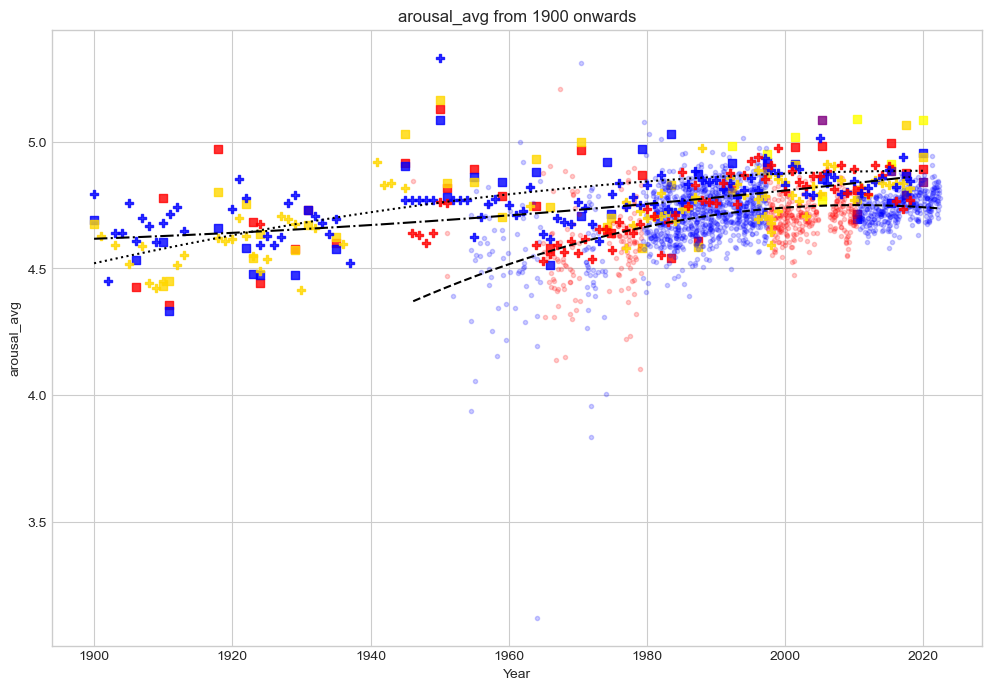

Cleaning:  60%|█████▉    | 1284/2142 [00:05<00:03, 233.26it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\natha\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-1ae55b9de6d2>", line 35, in <module>
    var_df.progress_apply(lambda row: ax.scatter(row.year, row.score,
  File "C:\Users\natha\anaconda3\lib\site-packages\tqdm\std.py", line 817, in inner
    return getattr(df, df_function)(wrapper, **kwargs)
  File "C:\Users\natha\anaconda3\lib\site-packages\pandas\core\frame.py", line 8741, in apply
    return op.apply()
  File "C:\Users\natha\anaconda3\lib\site-packages\pandas\core\apply.py", line 688, in apply
    return self.apply_standard()
  File "C:\Users\natha\anaconda3\lib\site-packages\pandas\core\apply.py", line 812, in apply_standard
    results, res_index = self.apply_series_generator()
  File "C:\Users\natha\anaconda3\lib\site-packages\pandas\core\apply.py", line 828, in apply_series_generator
    results[i] = self.

TypeError: object of type 'NoneType' has no len()

In [5]:
party_dict = {'Labour':'LAB',
              'Conservative':'CON',
              'Liberal':'LIB',
              'SDP-Liberal Alliance':'LIB',
              'Liberal Democrat':'LIB',
              np.nan:'NAN'}



for s_idx,scoring_var in enumerate(manifestos_scores[0].keys()):
    plt.clf()
    manifestos_df = pd.DataFrame({'score':[x[s_idx] for x in manifestos_vecs],
                                  'type':['manifesto']*len(manifestos_vecs),
                                  'year':manifestos.drop(manifestos_nans, axis=0).year,
                                  'party':manifestos.drop(manifestos_nans, axis=0).party})
    pmqs_df = pd.DataFrame({'score':[x[s_idx] for x in pmqs_vecs],
                           'type':['PMQs']*len(pmqs_vecs),
                           'year':pmqs.drop(pmqs_nans, axis=0).date,
                           'party':pmqs.drop(pmqs_nans, axis=0).answerer_party.apply(lambda party: party_dict[str(party)] if str(party) in party_dict.keys() else 'NAN')})
    conferences_df = pd.DataFrame({'score':[x[s_idx] for x in conferences_vecs],
                                   'type':['conference']*len(conferences_vecs),
                                   'year':conferences.drop(conferences_nans, axis=0).year,
                                   'party':conferences.drop(conferences_nans, axis=0).party.apply(lambda party: party_dict[party])})
    var_df = pd.DataFrame({'score':[],'type':[],'year':[],'party':[]})
    var_df = var_df.append(manifestos_df)
    var_df = var_df.append(pmqs_df)
    var_df = var_df.append(conferences_df)

    col_dict = {'LAB':'red','CON':'blue','LIB':'gold','SNP':'yellow','UKIP':'purple','BRX':'purple','NAN':'grey'}
    marker_dict = {'manifesto':'s','PMQs':'.','conference':'P'}
    alpha_dict = {'manifesto':0.8,'PMQs':0.2,'conference':0.8}

    plt.style.use('seaborn-whitegrid')
    fig,ax = plt.subplots(1, figsize=(12,8))
    var_df.progress_apply(lambda row: ax.scatter(row.year, row.score,
                                                              color=col_dict[row.party],
                                                              marker=marker_dict[row.type],
                                                              alpha=alpha_dict[row.type]),
                                       axis=1)

    # Plot line of best fit for manifestos
    deg = 2
    x = np.array([date for date in manifestos.drop(manifestos_nans, axis=0).year])
    native_x = [int(xi.timestamp() * 10**9) for xi in x] # convert x to native timestamp
    y = np.array([score_dict[scoring_var] for score_dict in manifestos_scores])
    coefs = np.polyfit(native_x, y, deg=deg)
    xseq = np.linspace(min(native_x)-1, max(native_x)+1, num=500)
    XX = np.vstack([xseq**(deg-i) for i in range(deg+1)]).T # rows 1, x, x**2, ...
    yseq = np.dot(XX, coefs)  # matrix multiplication by coefs calculates the polynomial values
    ax.plot(pd.to_datetime(xseq), yseq, ':', color='black')
    # ...PMQs
    x = np.array([date for date in pmqs.drop(pmqs_nans, axis=0).date])
    native_x = [int(xi.timestamp() * 10**9) for xi in x] # convert x to native timestamp
    y = np.array([score_dict[scoring_var] for score_dict in pmqs_scores])
    coefs = np.polyfit(native_x, y, deg=deg)
    xseq = np.linspace(min(native_x)-1, max(native_x)+1, num=500)
    XX = np.vstack([xseq**(deg-i) for i in range(deg+1)]).T # rows 1, x, x**2, ...
    yseq = np.dot(XX, coefs)  # matrix multiplication by coefs calculates the polynomial values
    ax.plot(pd.to_datetime(xseq), yseq, '--', color='black')
    # ...and conference speeches
    x = np.array([date for date in conferences.drop(conferences_nans, axis=0).year])
    native_x = [int(xi.timestamp() * 10**9) for xi in x] # convert x to native timestamp
    y = np.array([score_dict[scoring_var] for score_dict in conferences_scores])
    coefs = np.polyfit(native_x, y, deg=deg)
    xseq = np.linspace(min(native_x)-1, max(native_x)+1, num=500)
    XX = np.vstack([xseq**(deg-i) for i in range(deg+1)]).T # rows 1, x, x**2, ...
    yseq = np.dot(XX, coefs)  # matrix multiplication by coefs calculates the polynomial values
    ax.plot(pd.to_datetime(xseq), yseq, '-.', color='black')
    ax.set_xlabel("Year")
    ax.set_ylabel(scoring_var)
    ax.set_title(scoring_var+" from 1900 onwards")
    plt.show()

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

current_day = datetime.strftime(datetime.now(), format="%Y-%m-%d")
pm_list = [['Robert Gascoyne-Cecil',('1895-06-25','1902-07-11')],
               ['Arthur Balfour',('1902-07-12','1905-12-04')],
               ['Henry Campbell-Bannerman',('1905-12-05','1908-04-03')],
               ['H.H. Asquith',('1908-04-04','1916-12-05')],
               ['David Lloyd George',('1916-12-06','1922-10-19')],
               ['Andrew Bonar Law',('1922-10-20','1923-05-20')],
               ['Stanley Baldwin (1)',('1923-05-21','1924-01-22')],
               ['Ramsay MacDonald (1)',('1924-01-23','1924-11-04')],
               ['Stanley Baldwin (2)',('1924-11-05','1929-06-04')],
               ['Ramsay MacDonald (2)',('1929-06-05','1935-06-07')],
               ['Stanley Baldwin (3)',('1935-06-08','1937-05-28')],
               ['Neville Chamberlain',('1937-05-29','1940-05-09')],
               ['Winston Churchill (1)',('1940-05-10','1945-07-26')],
               ['Clement Attlee',('1945-07-27','1951-10-26')],
               ['Winston Churchill (2)',('1951-10-27','1955-04-05')],
               ['Anthony Eden',('1955-04-06','1957-01-09')],
               ['Harold Macmillan',('1957-01-10','1963-10-18')],
               ['Alec Douglas-Home',('1963-10-19','1964-10-16')],
               ['Harold Wilson (1)',('1964-10-17','1970-06-19')],
               ['Edward Heath',('1970-06-20','1974-03-04')],
               ['Harold Wilson (2)',('1974-03-05','1976-04-05')],
               ['James Callaghan',('1976-04-06','1979-05-04')],               
               ['Margaret Thatcher',('1979-05-05','1990-11-28')],
               ['John Major',('1990-11-29','1997-05-02')],
               ['Tony Blair',('1997-05-03','2007-06-27')],
               ['Gordon Brown',('2007-06-28','2010-05-11')],
               ['David Cameron',('2010-05-12','2016-07-13')],
               ['Theresa May',('2016-07-14','2019-07-24')],
               ['Boris Johnson',('2019-07-25',current_day)]]
pmqs = pd.read_csv('../hansard-pmqs/hansard_pmqs.csv')
pmqs.date = pd.to_datetime(pmqs.date)
pmqs = pmqs[pmqs.date>='1900-01-01']
pmqs = pd.DataFrame({'date':pmqs.groupby(by='date').answer_text.aggregate(lambda x: ''.join(x)).index,
                     'answer_text':pmqs.groupby(by='date').answer_text.aggregate(lambda x: ''.join(x)),
                     'answerer_party':pmqs.groupby(by='date').answerer_party.aggregate(lambda x: x.mode()),
                     'answerer_name':pmqs.groupby(by='date').answerer_name.aggregate(lambda x: x.mode())})
pmqs['answerer_name'] = pmqs.date.apply(lambda date: [pm for pm,(start_date,end_date) in pm_list if date>=pd.to_datetime(start_date) and date<=pd.to_datetime(end_date)][0])
pmqs['score'] = [x for x in pmqs_scores]
pmqs = pmqs[pmqs.answerer_party.apply(lambda party: party in ['Conservative','Labour'])]

<ipython-input-15-3f5163d94380>:45: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  pmqs = pmqs[pmqs.answerer_party.apply(lambda party: party in ['Conservative','Labour'])]


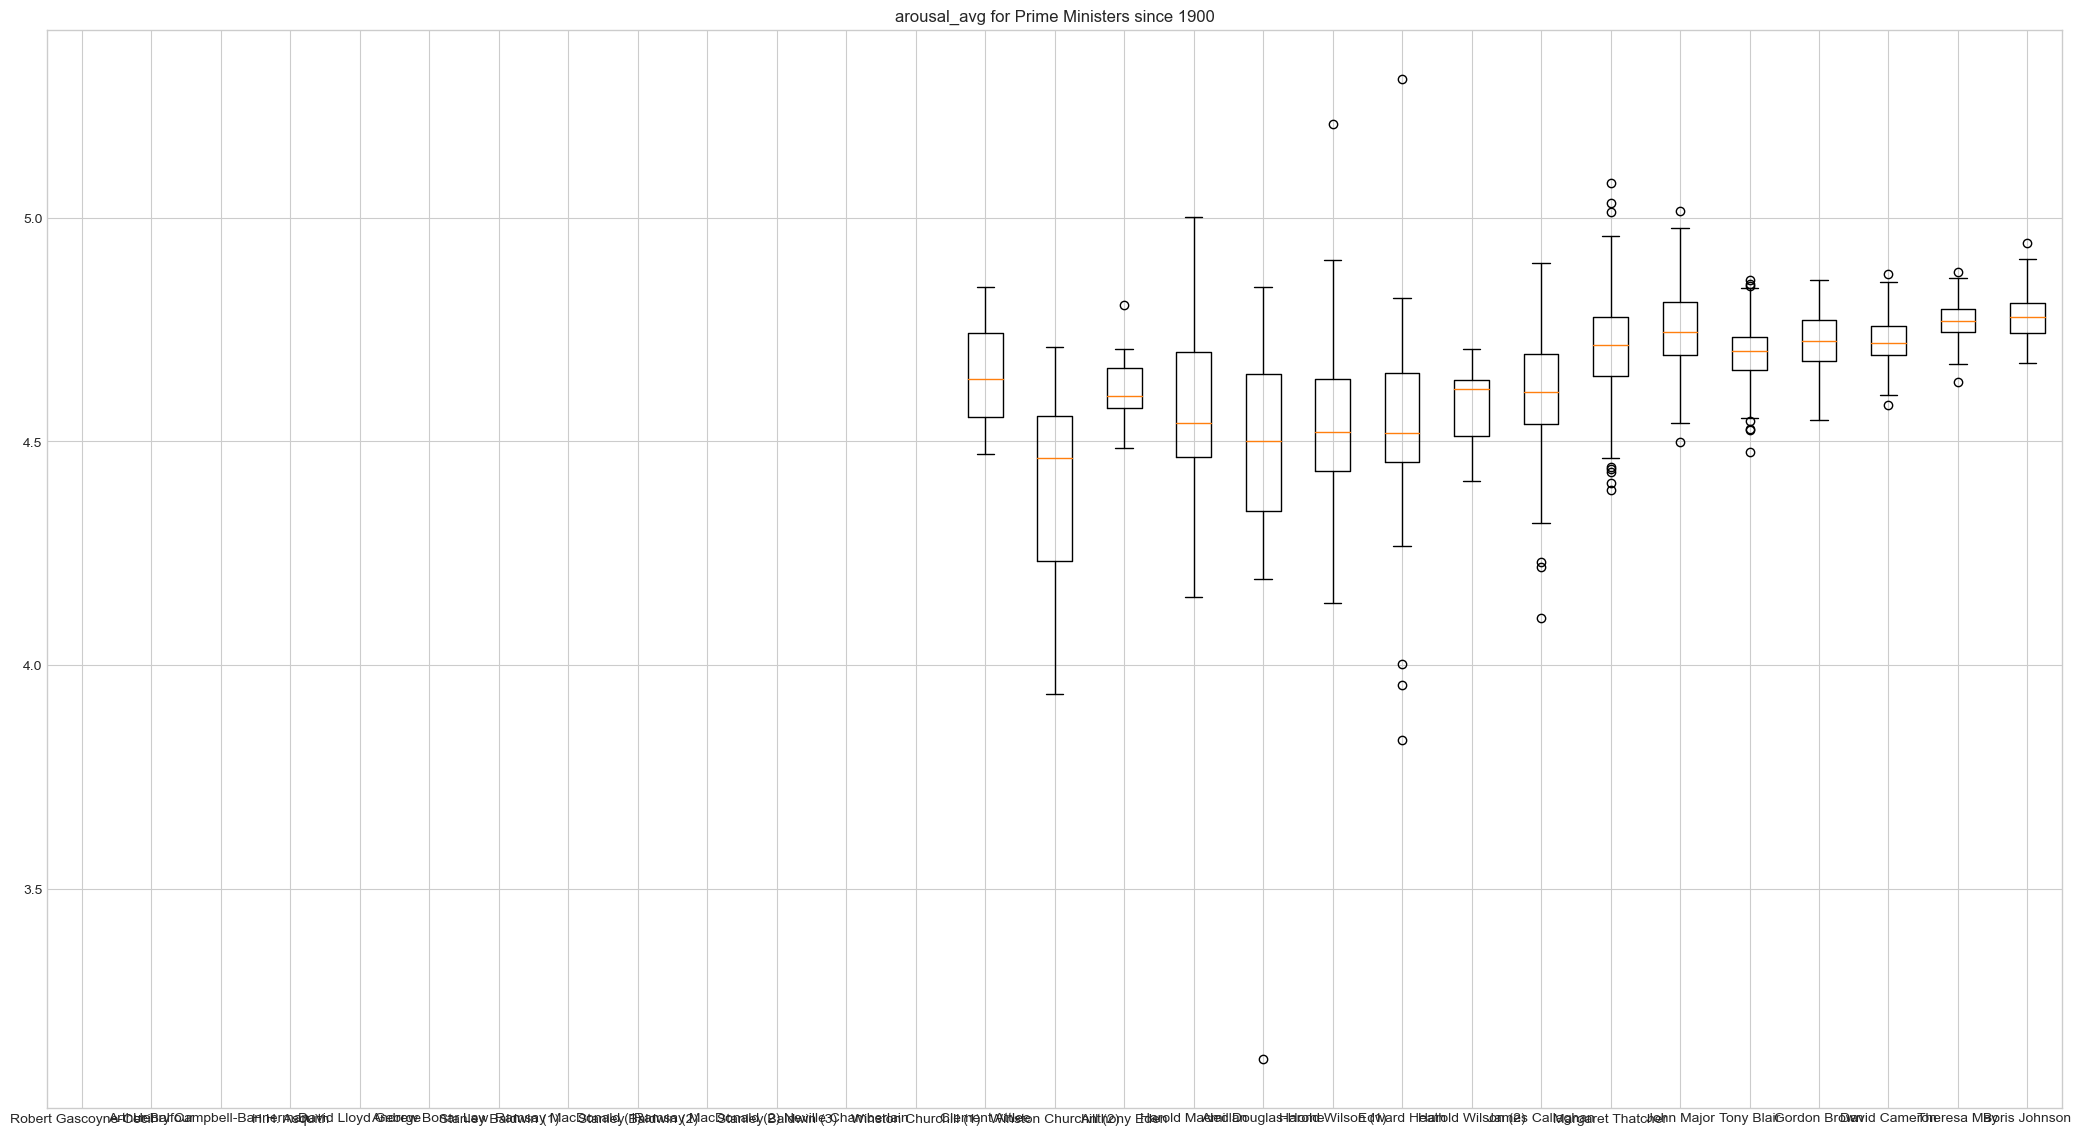

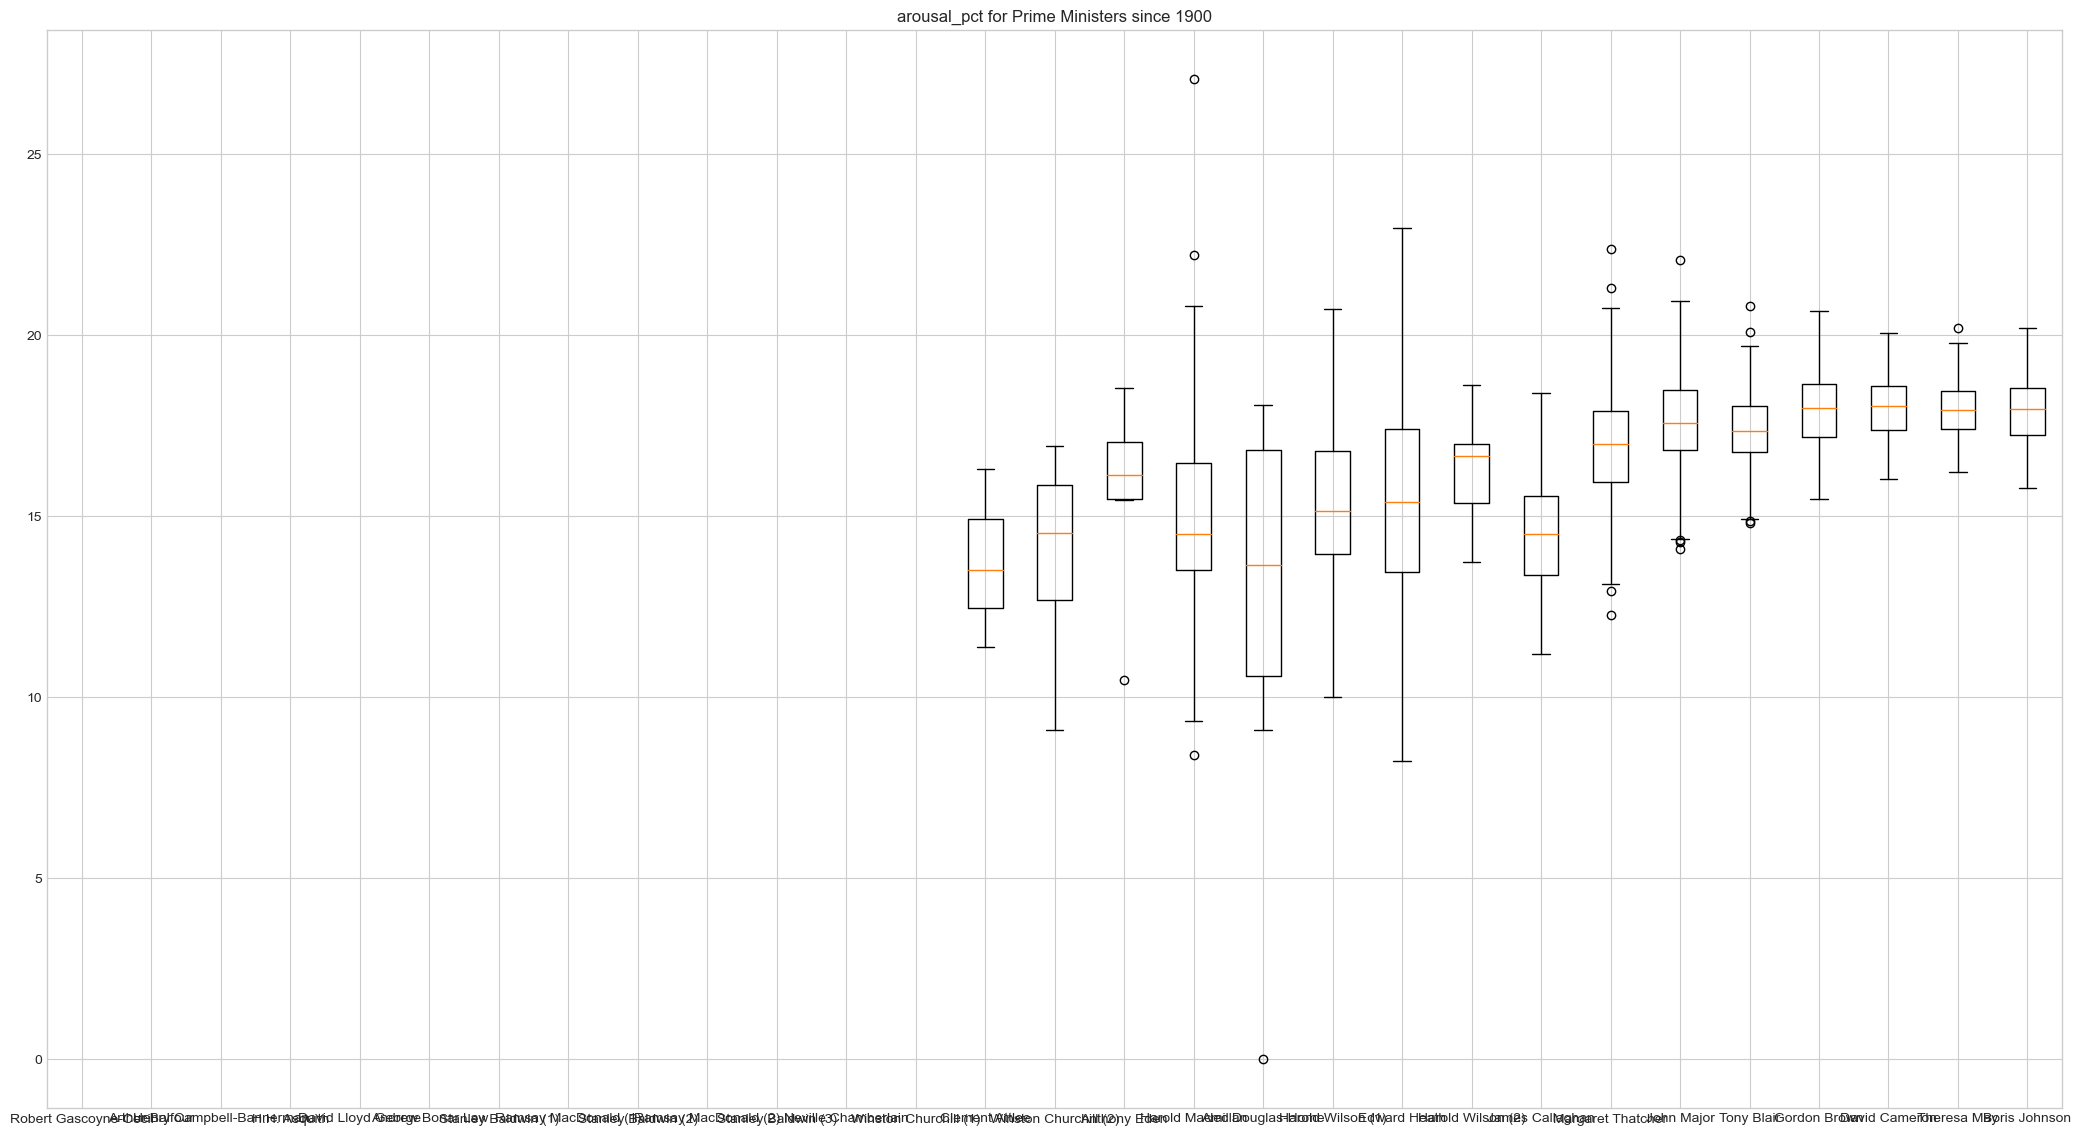

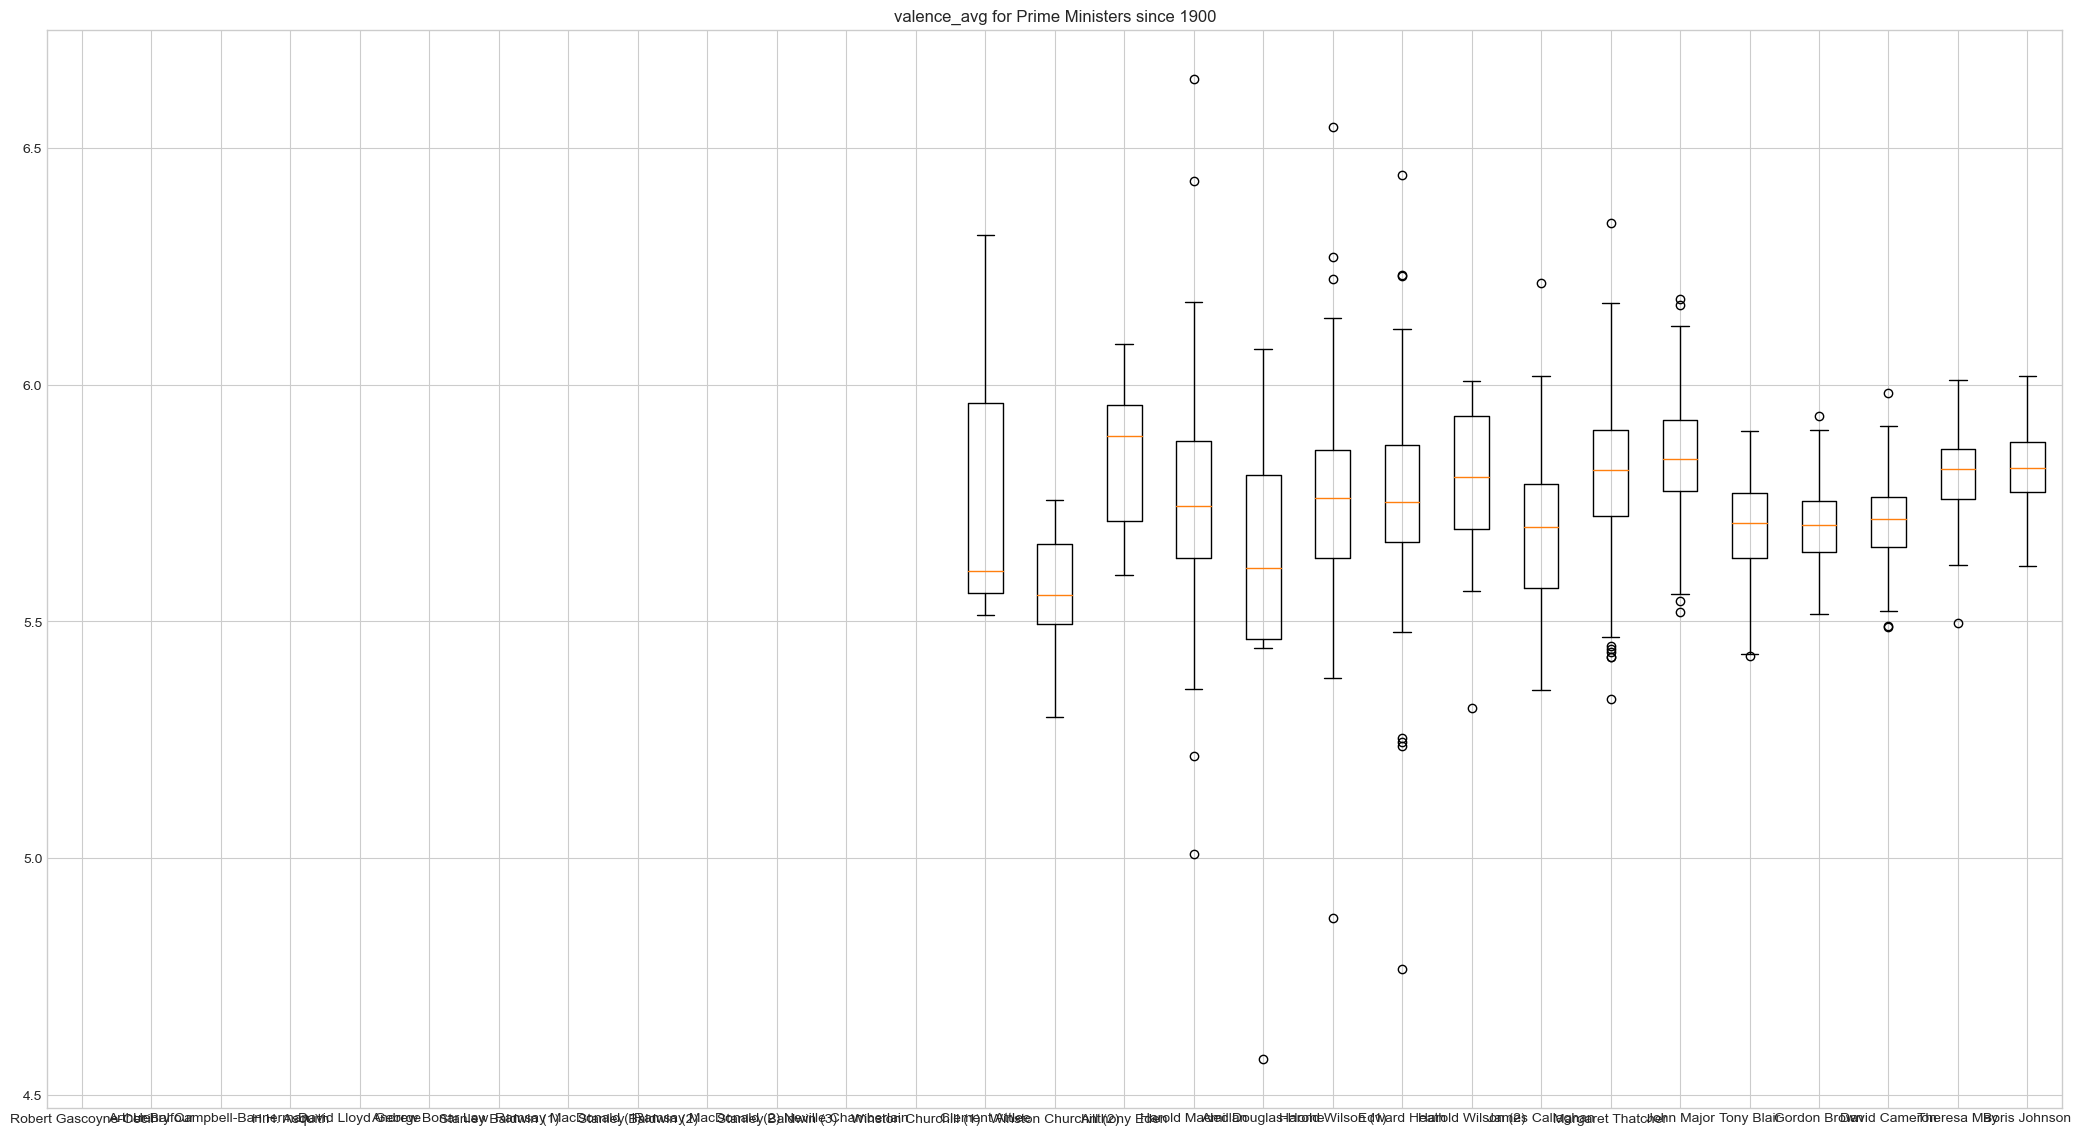

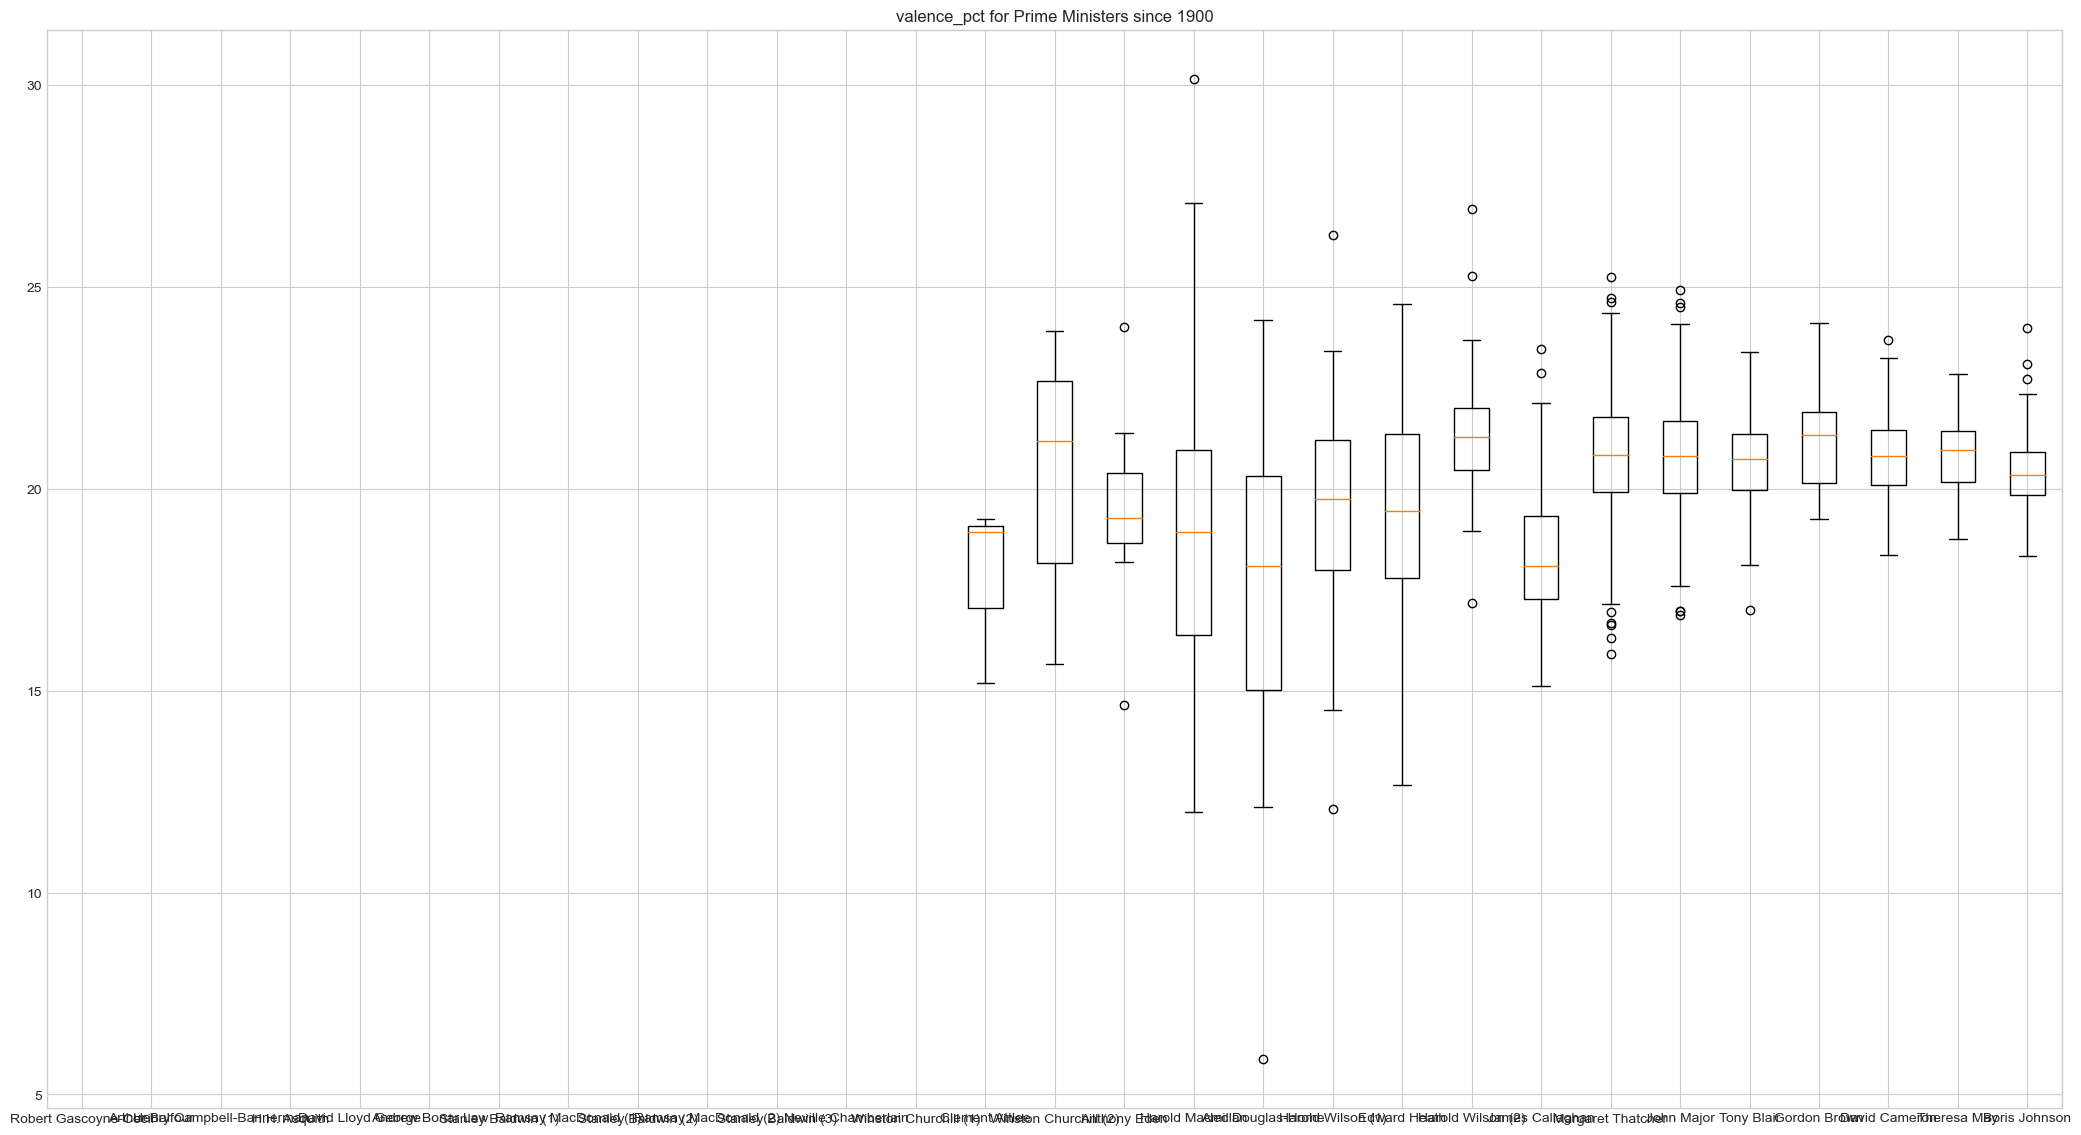

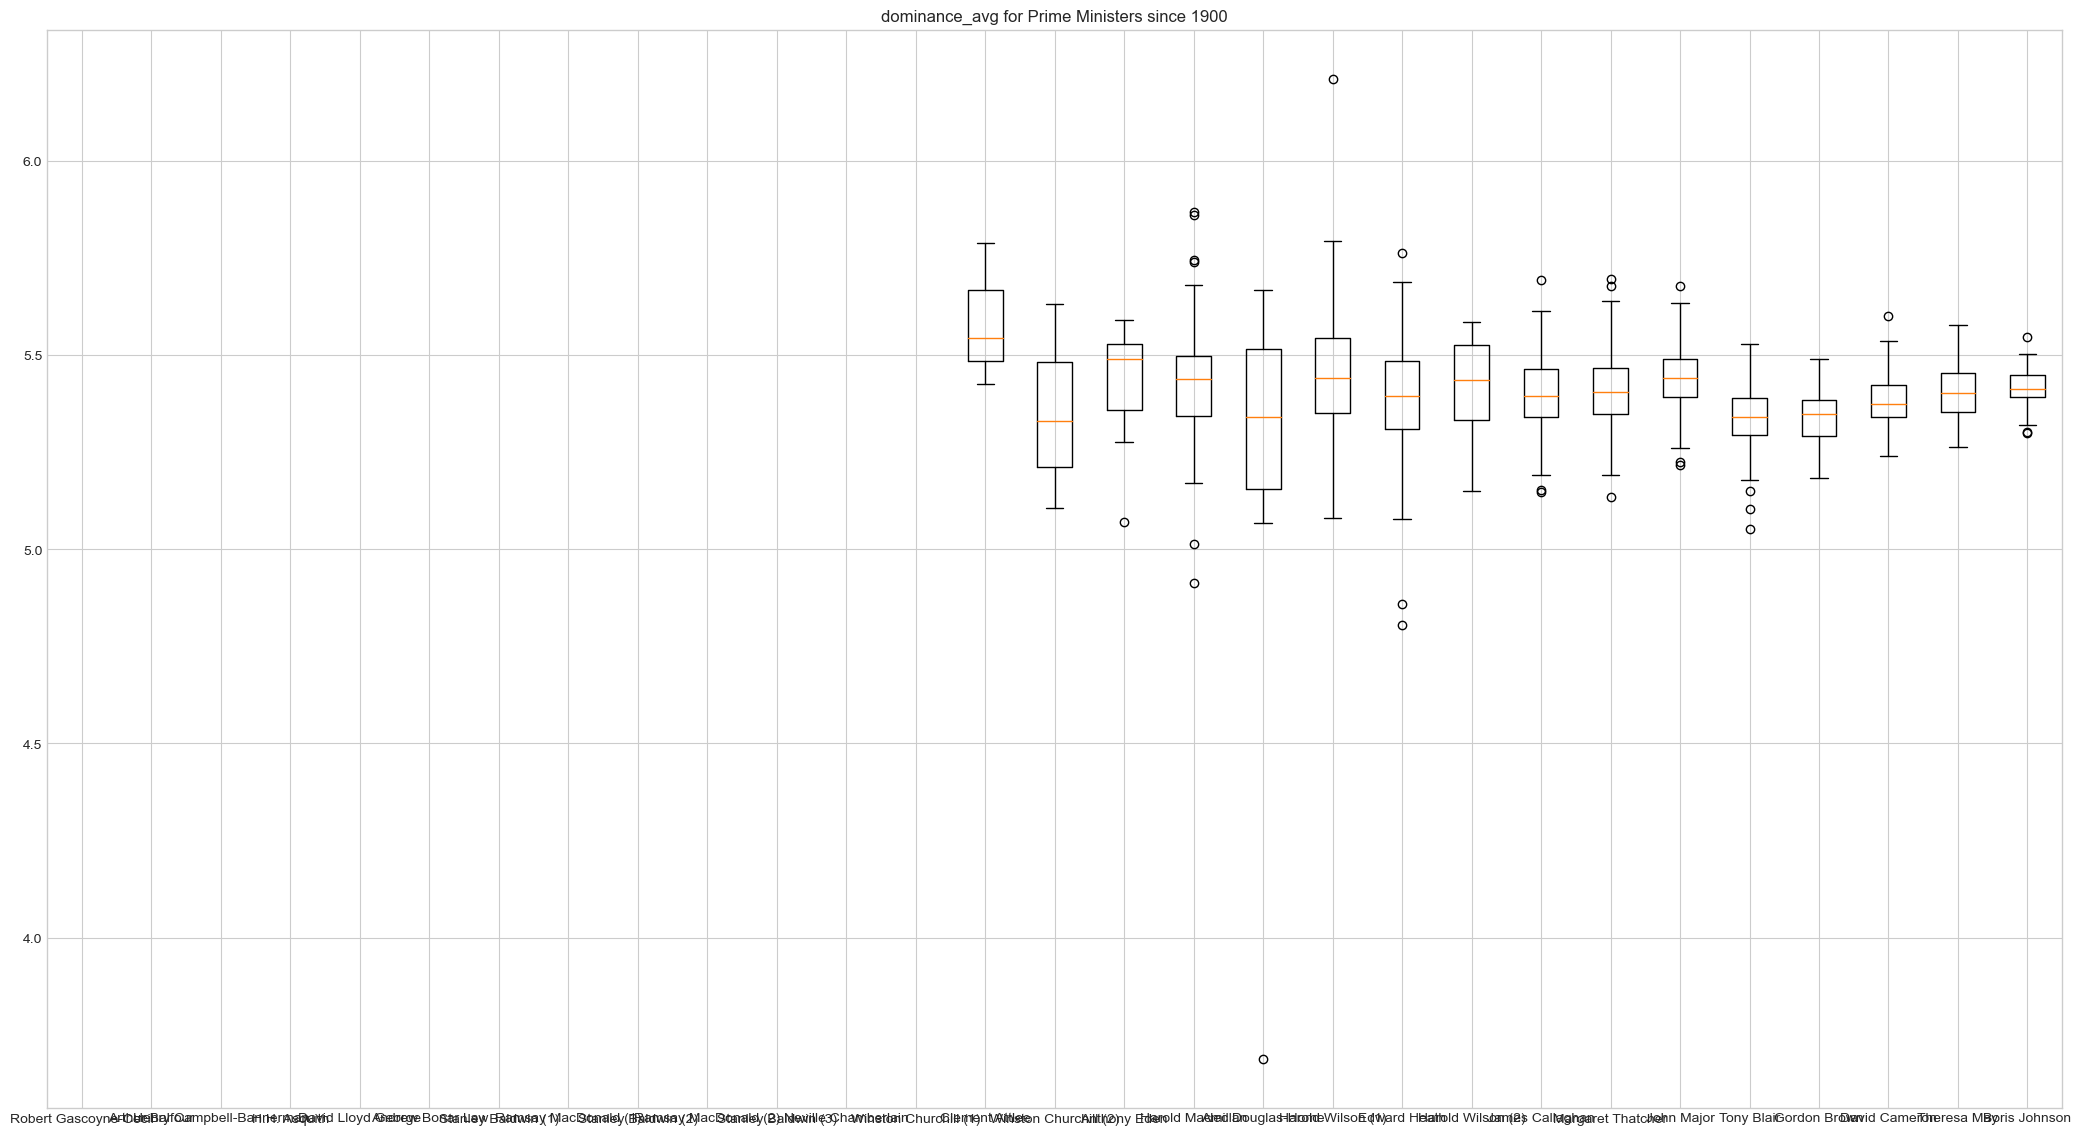

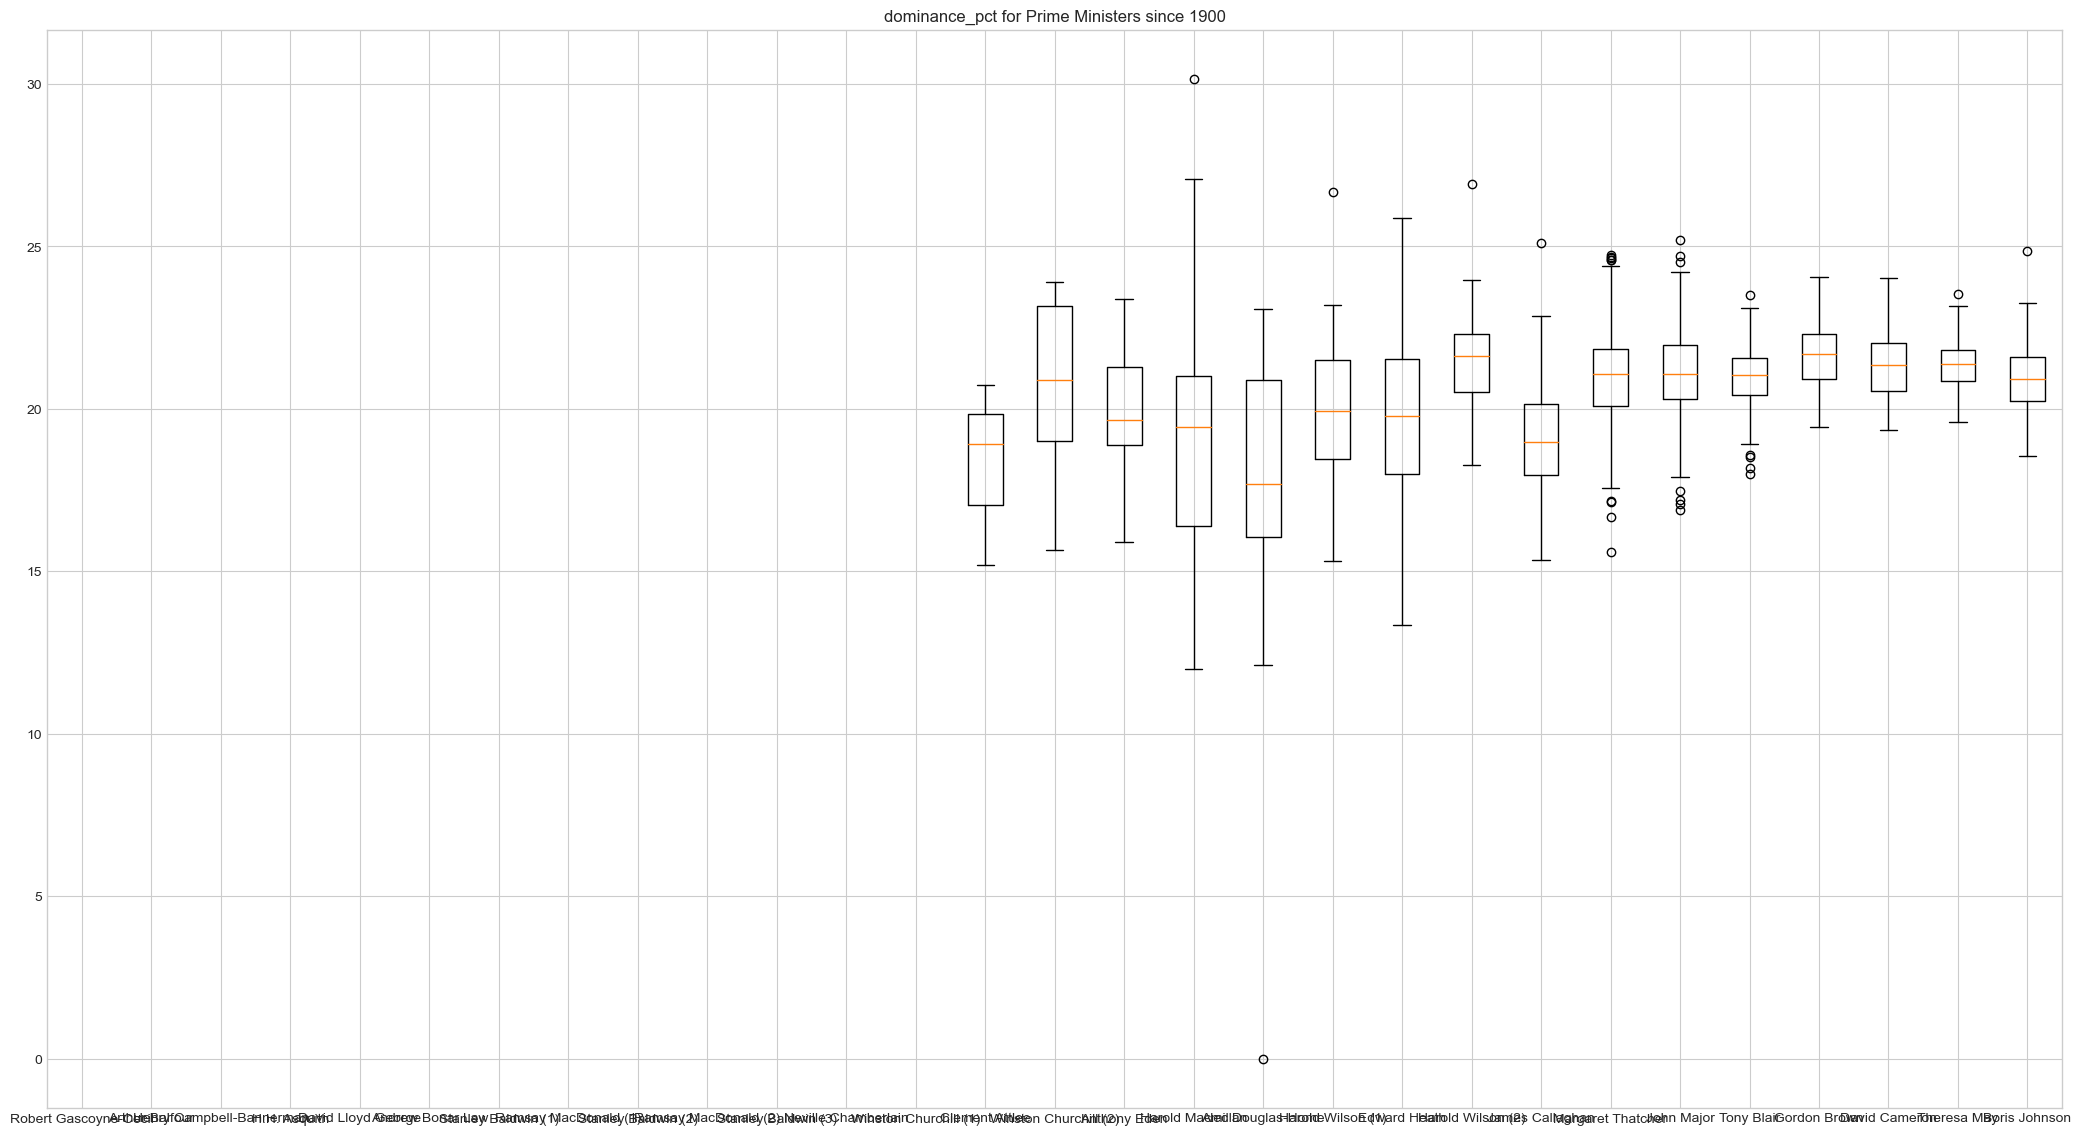

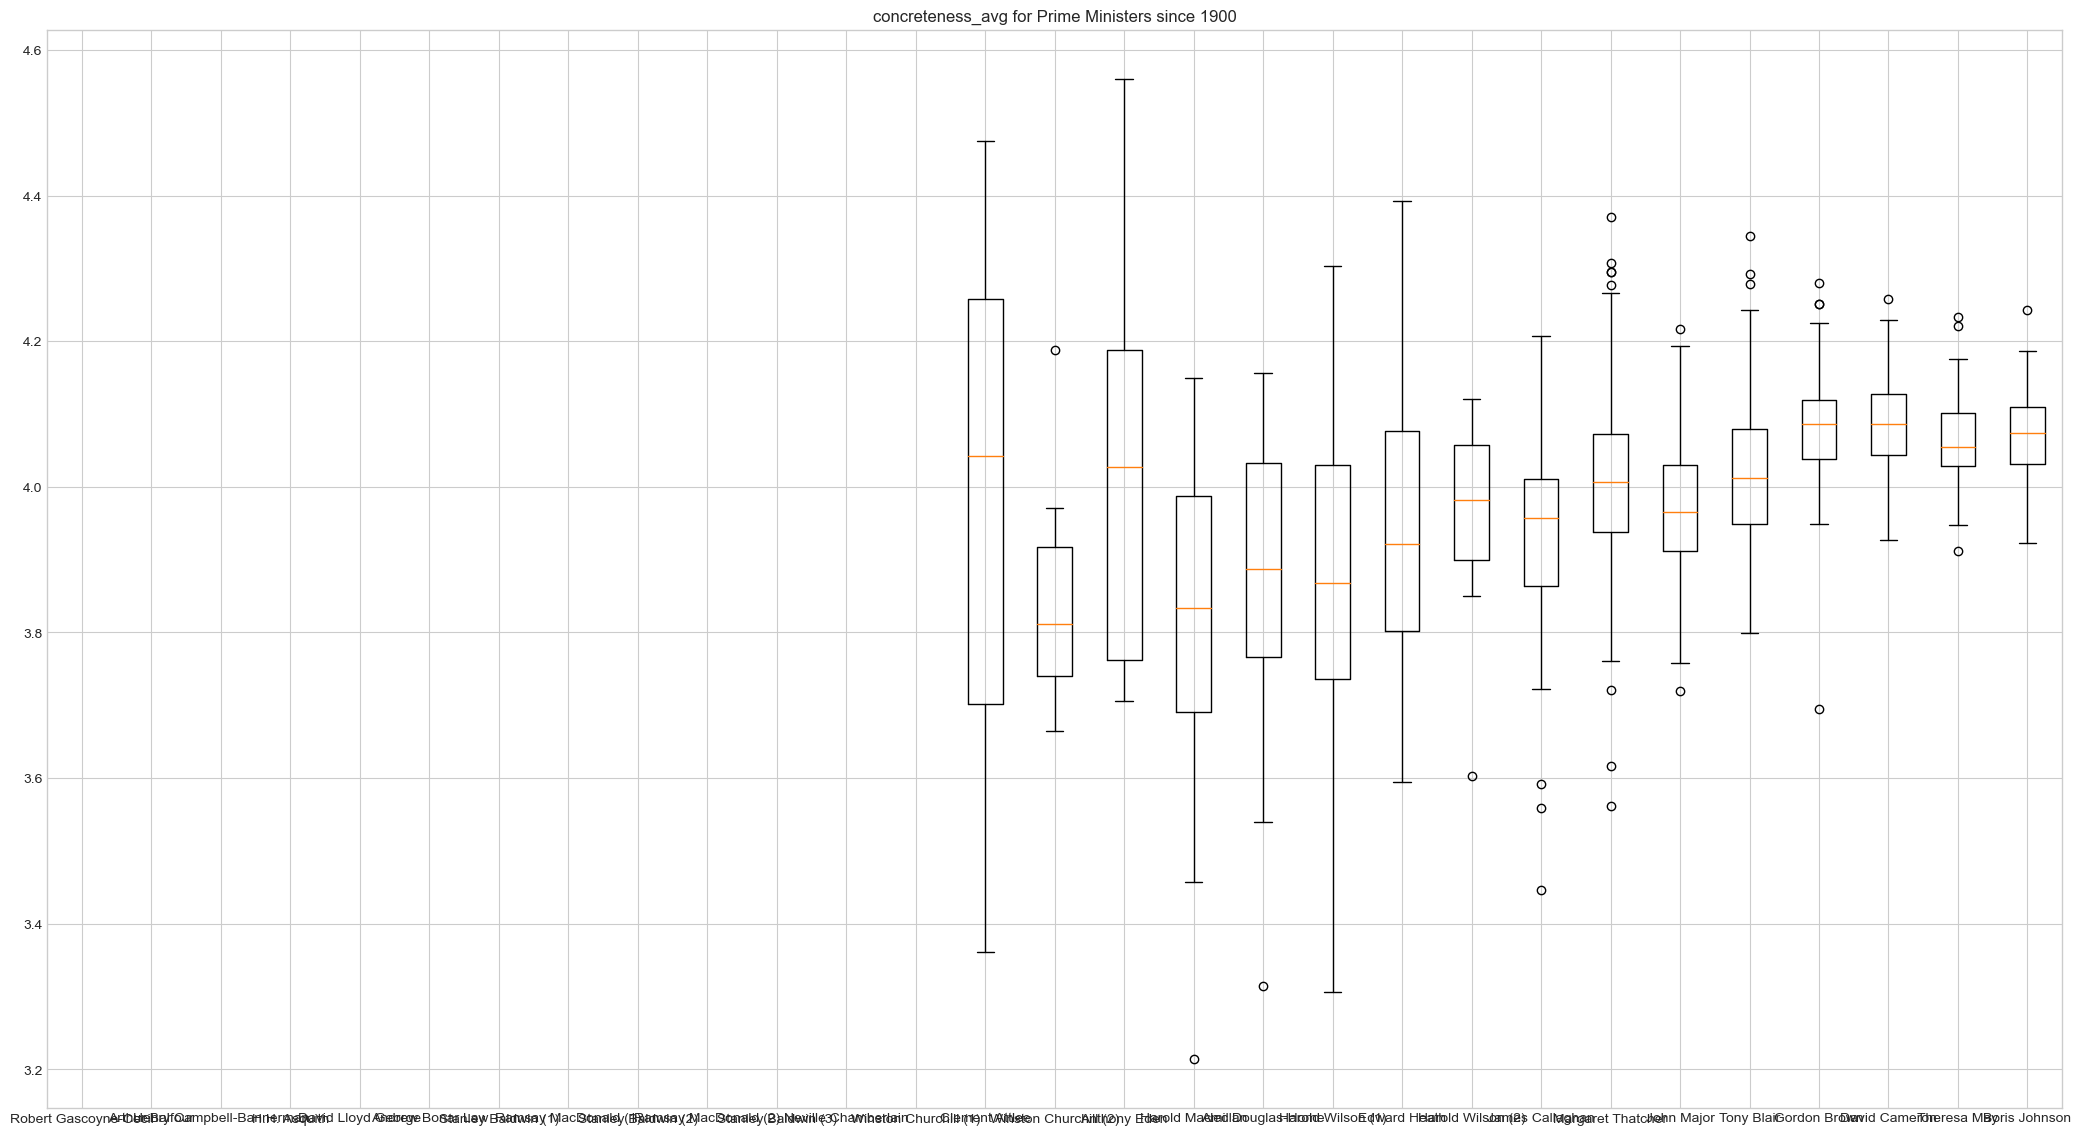

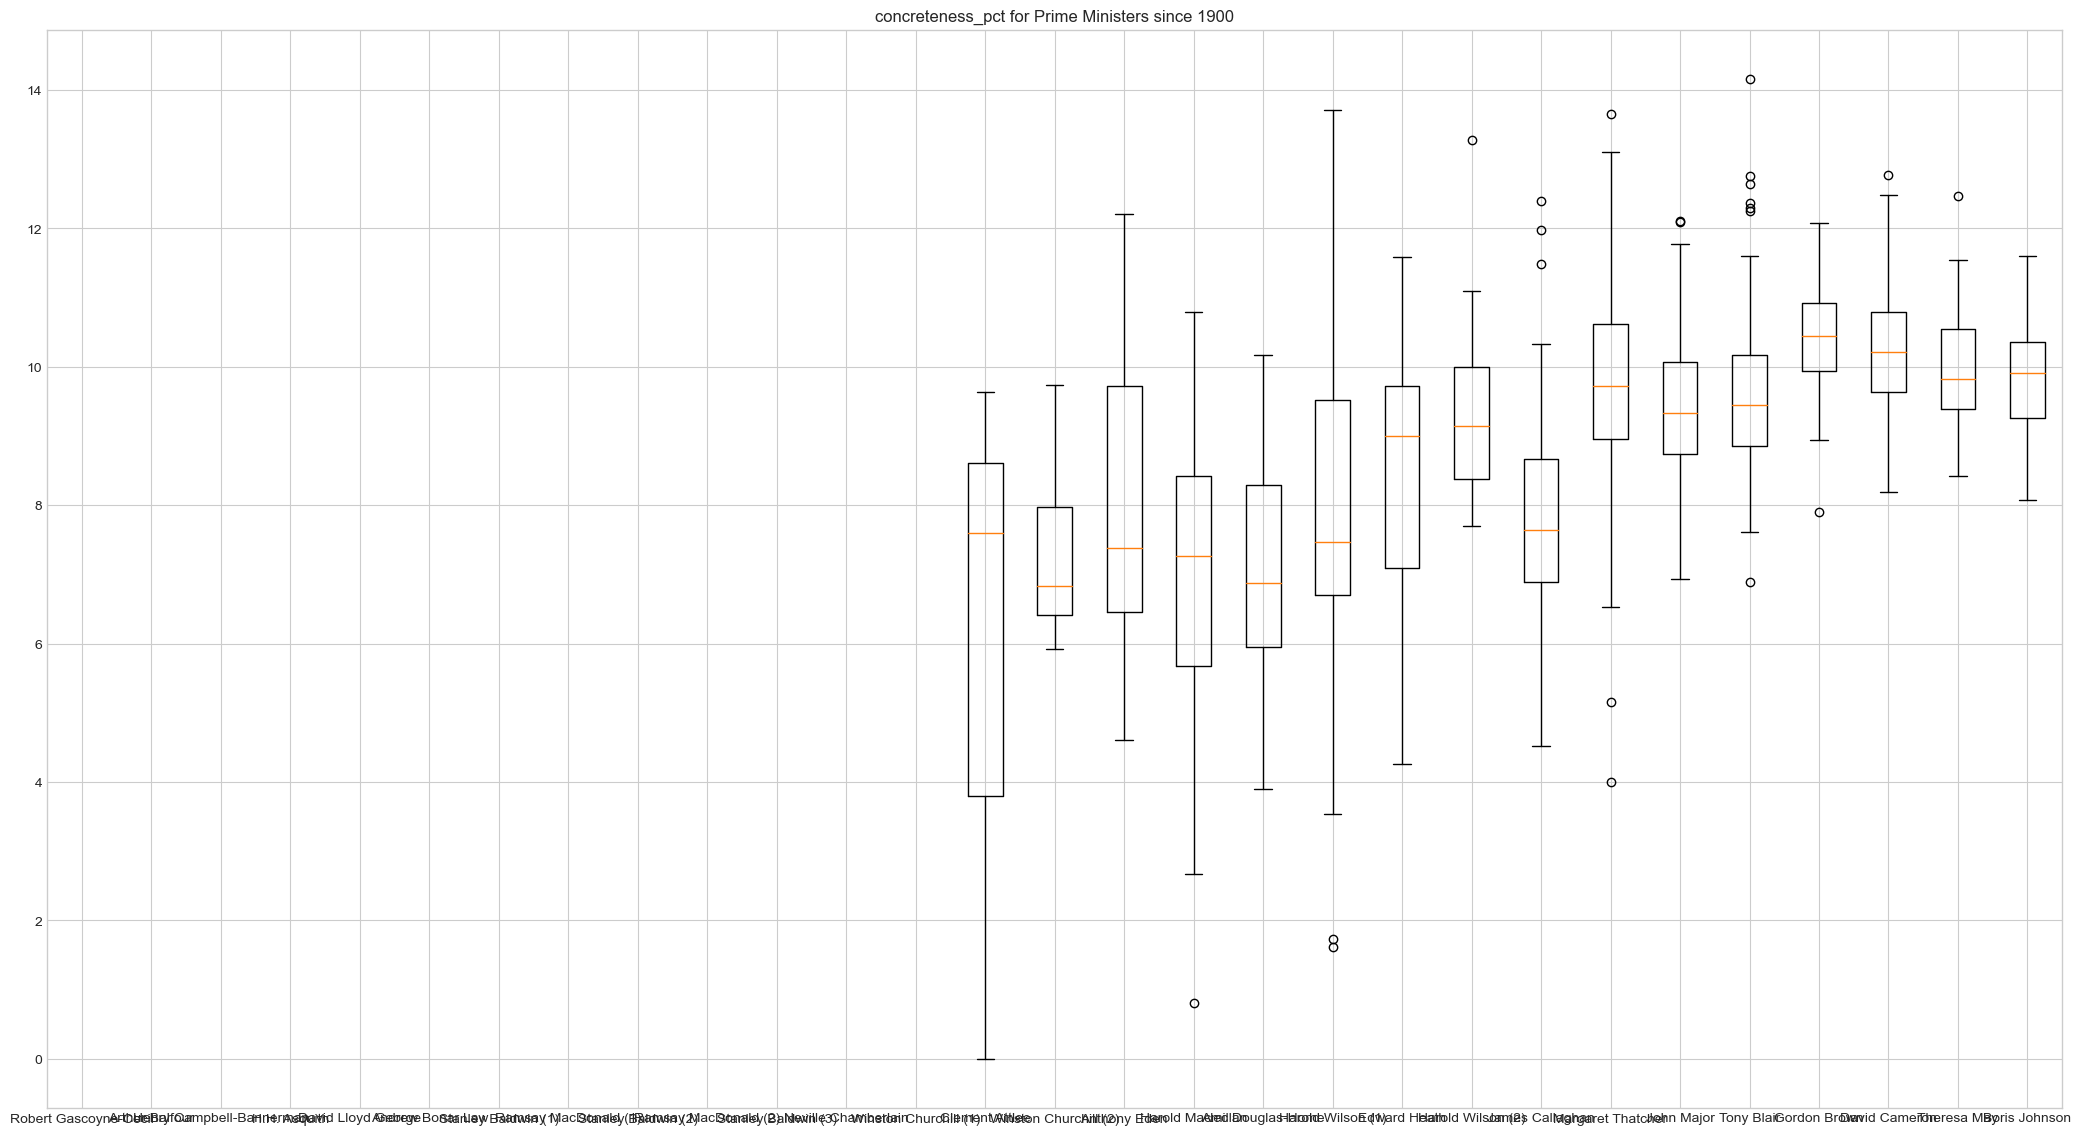

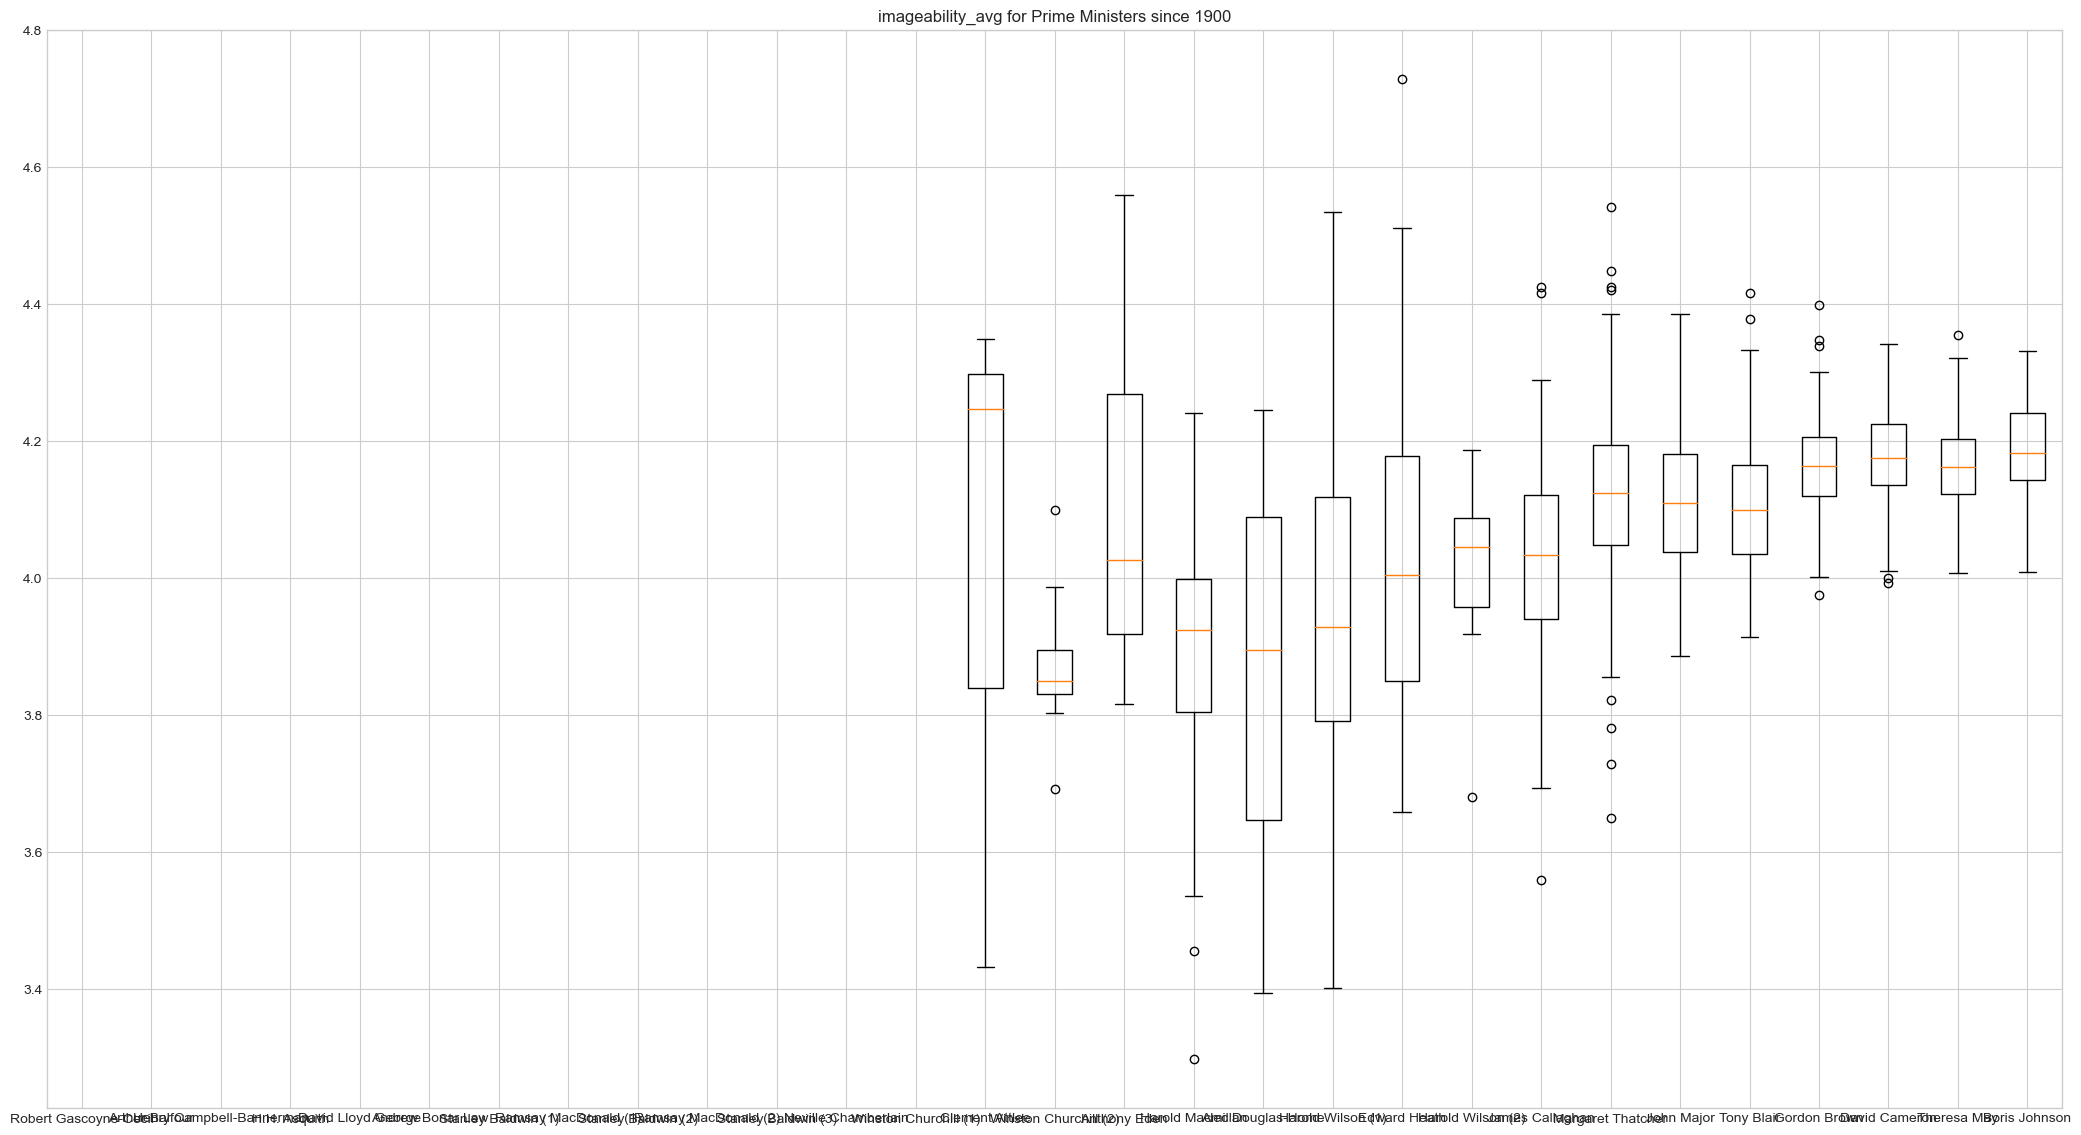

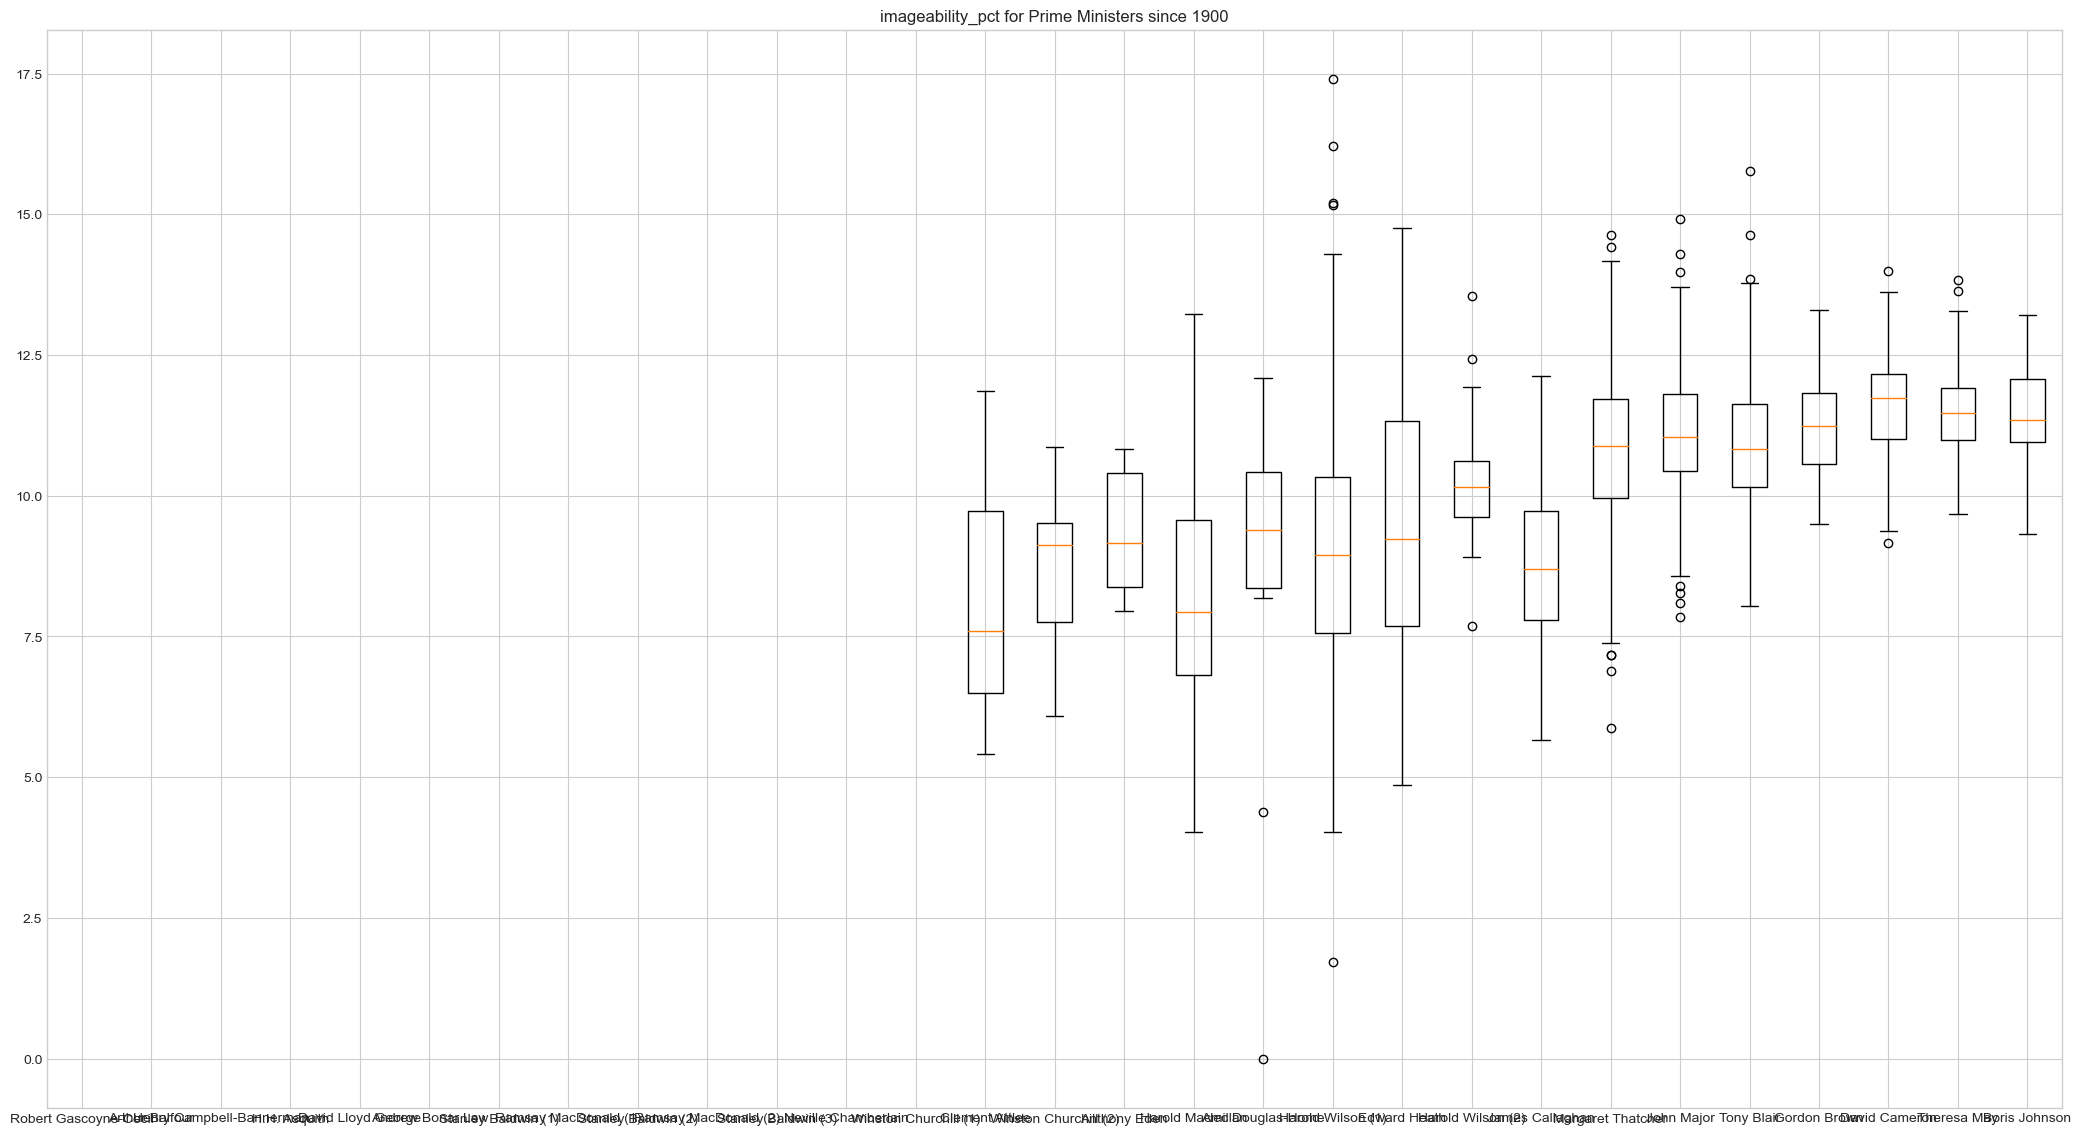

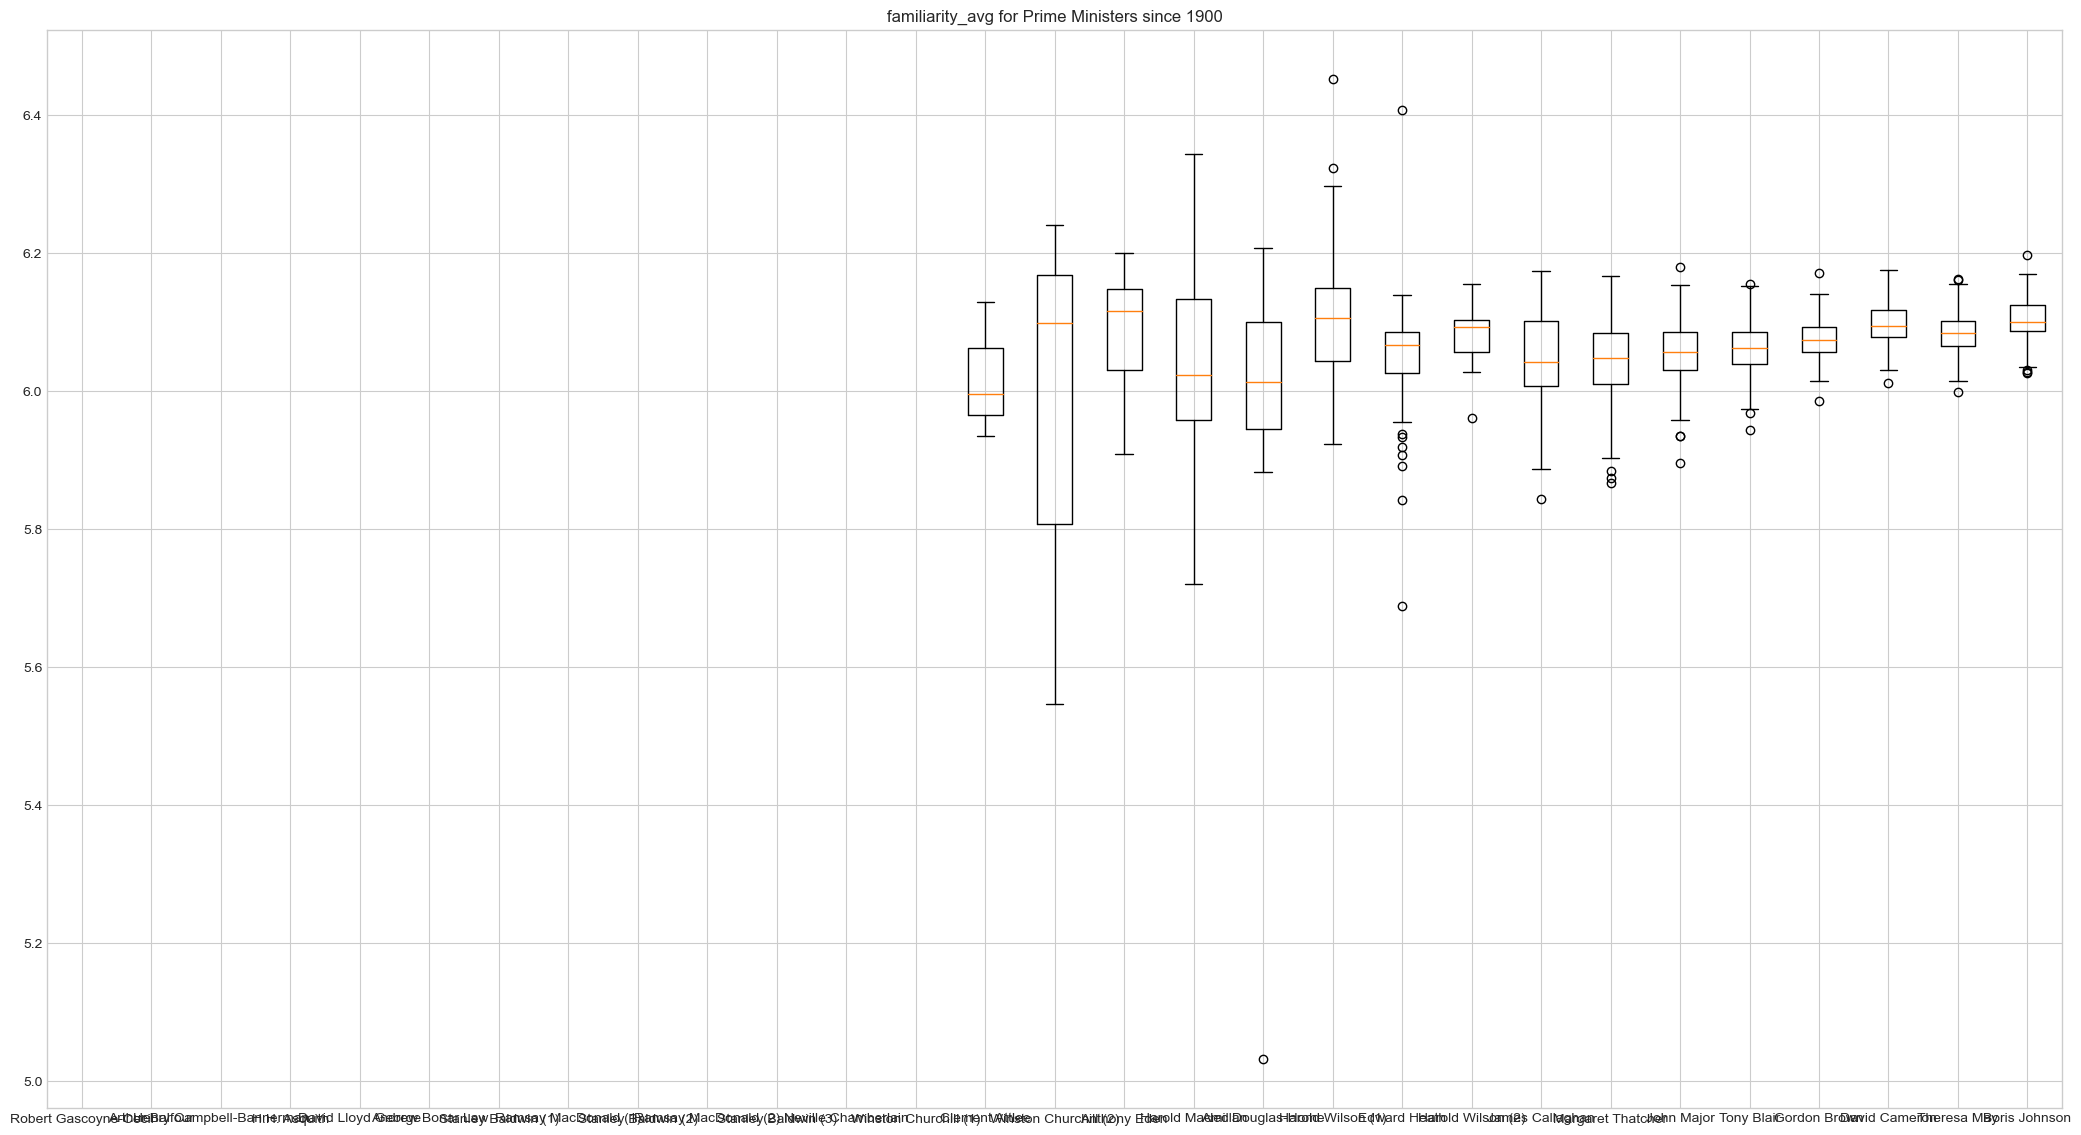

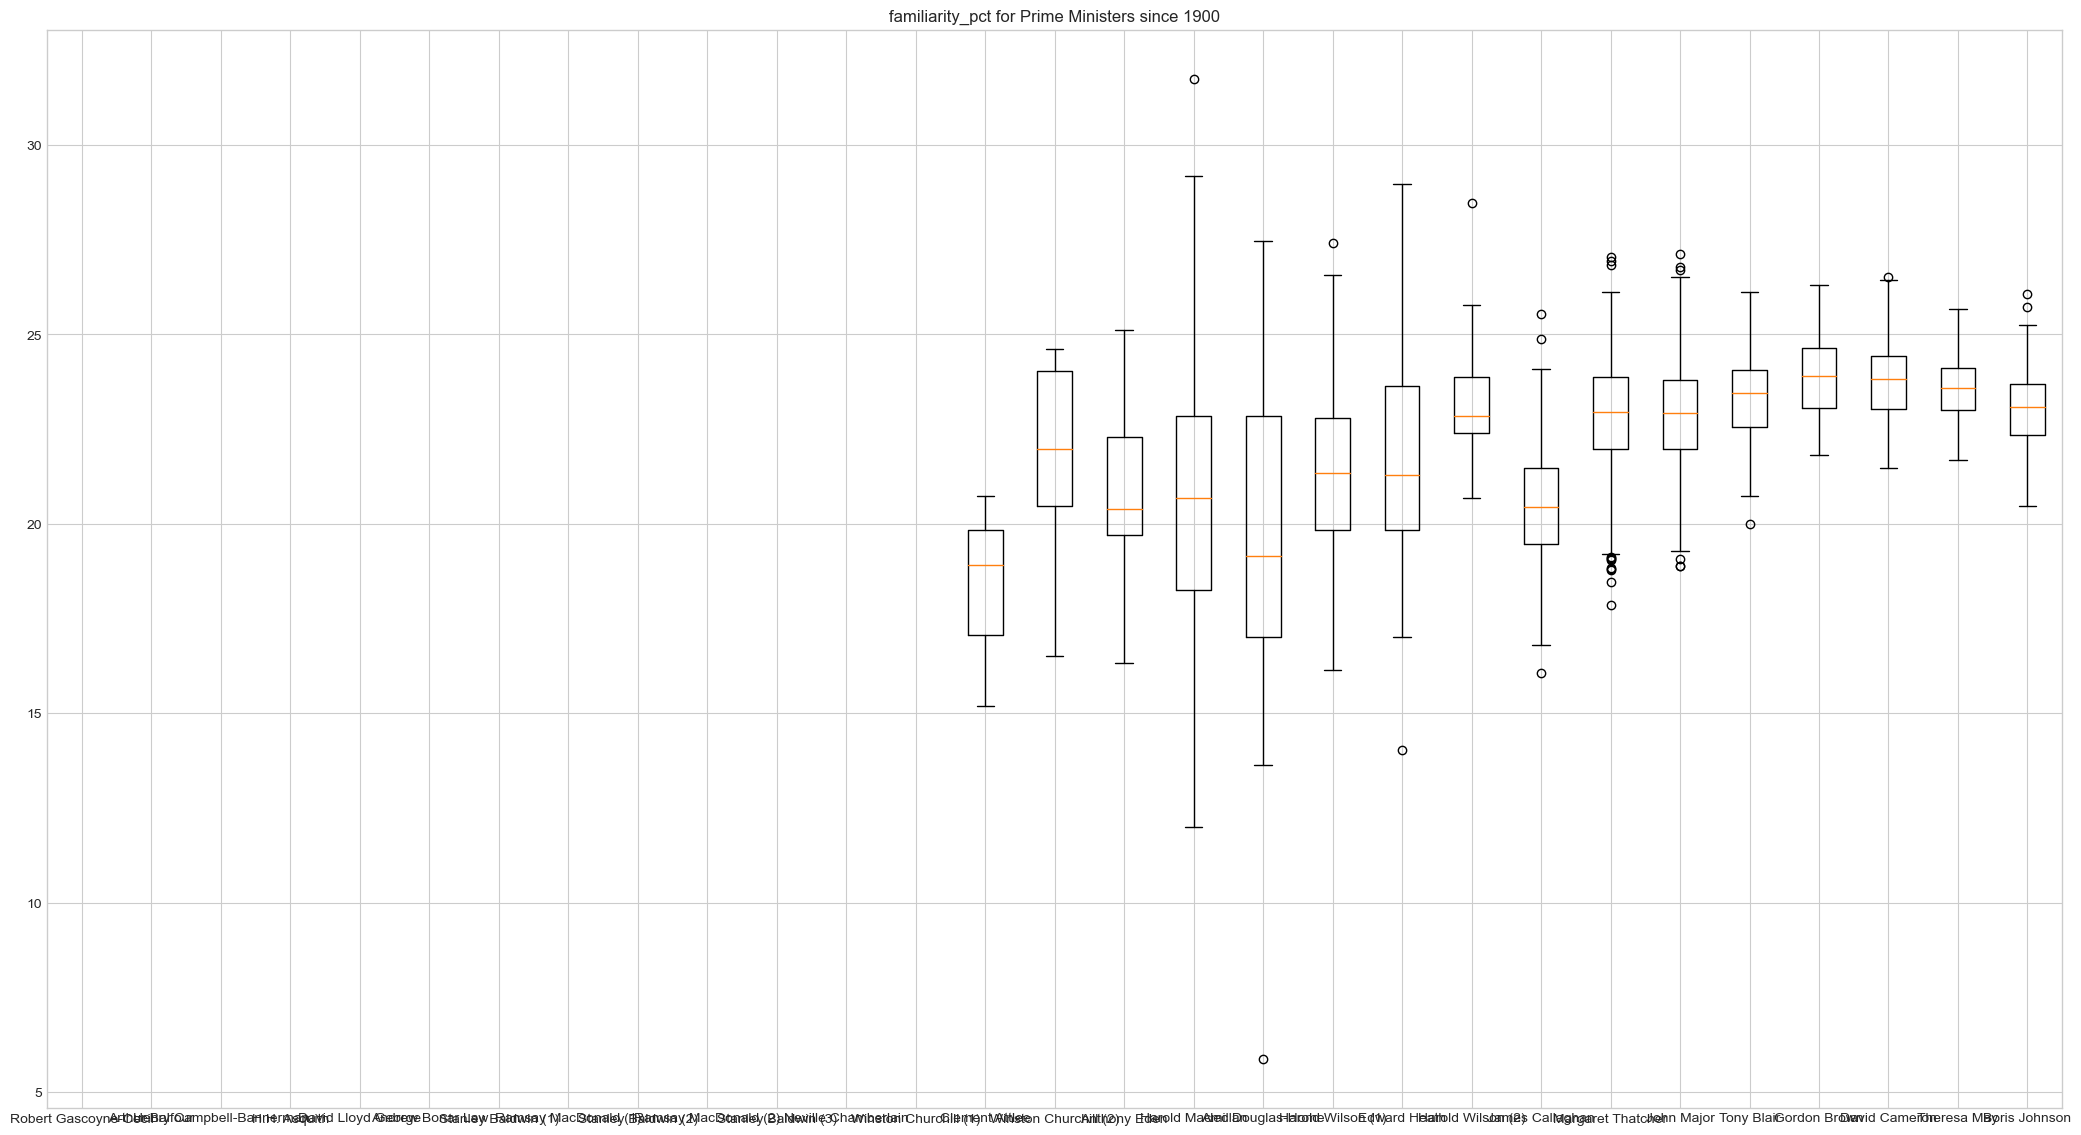

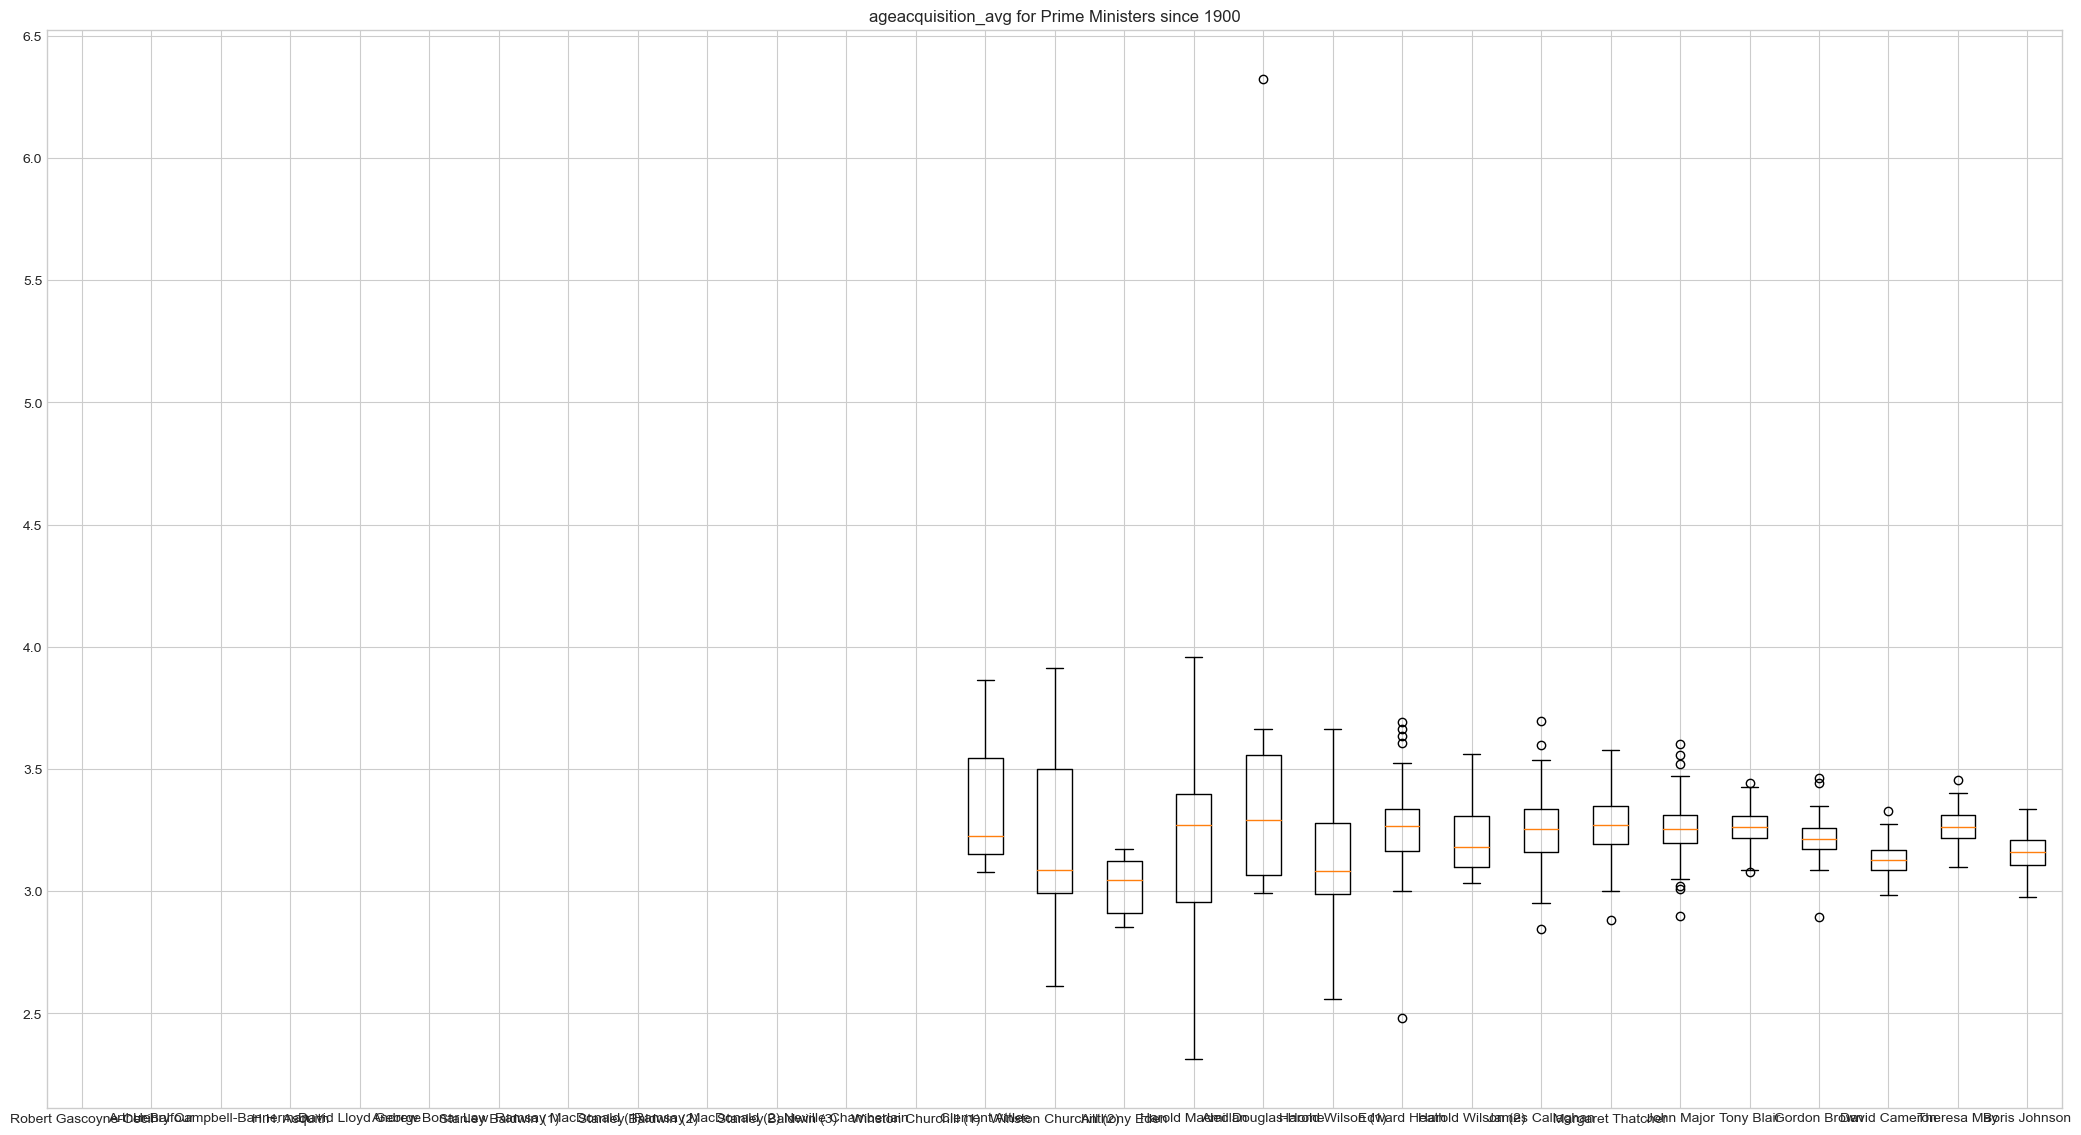

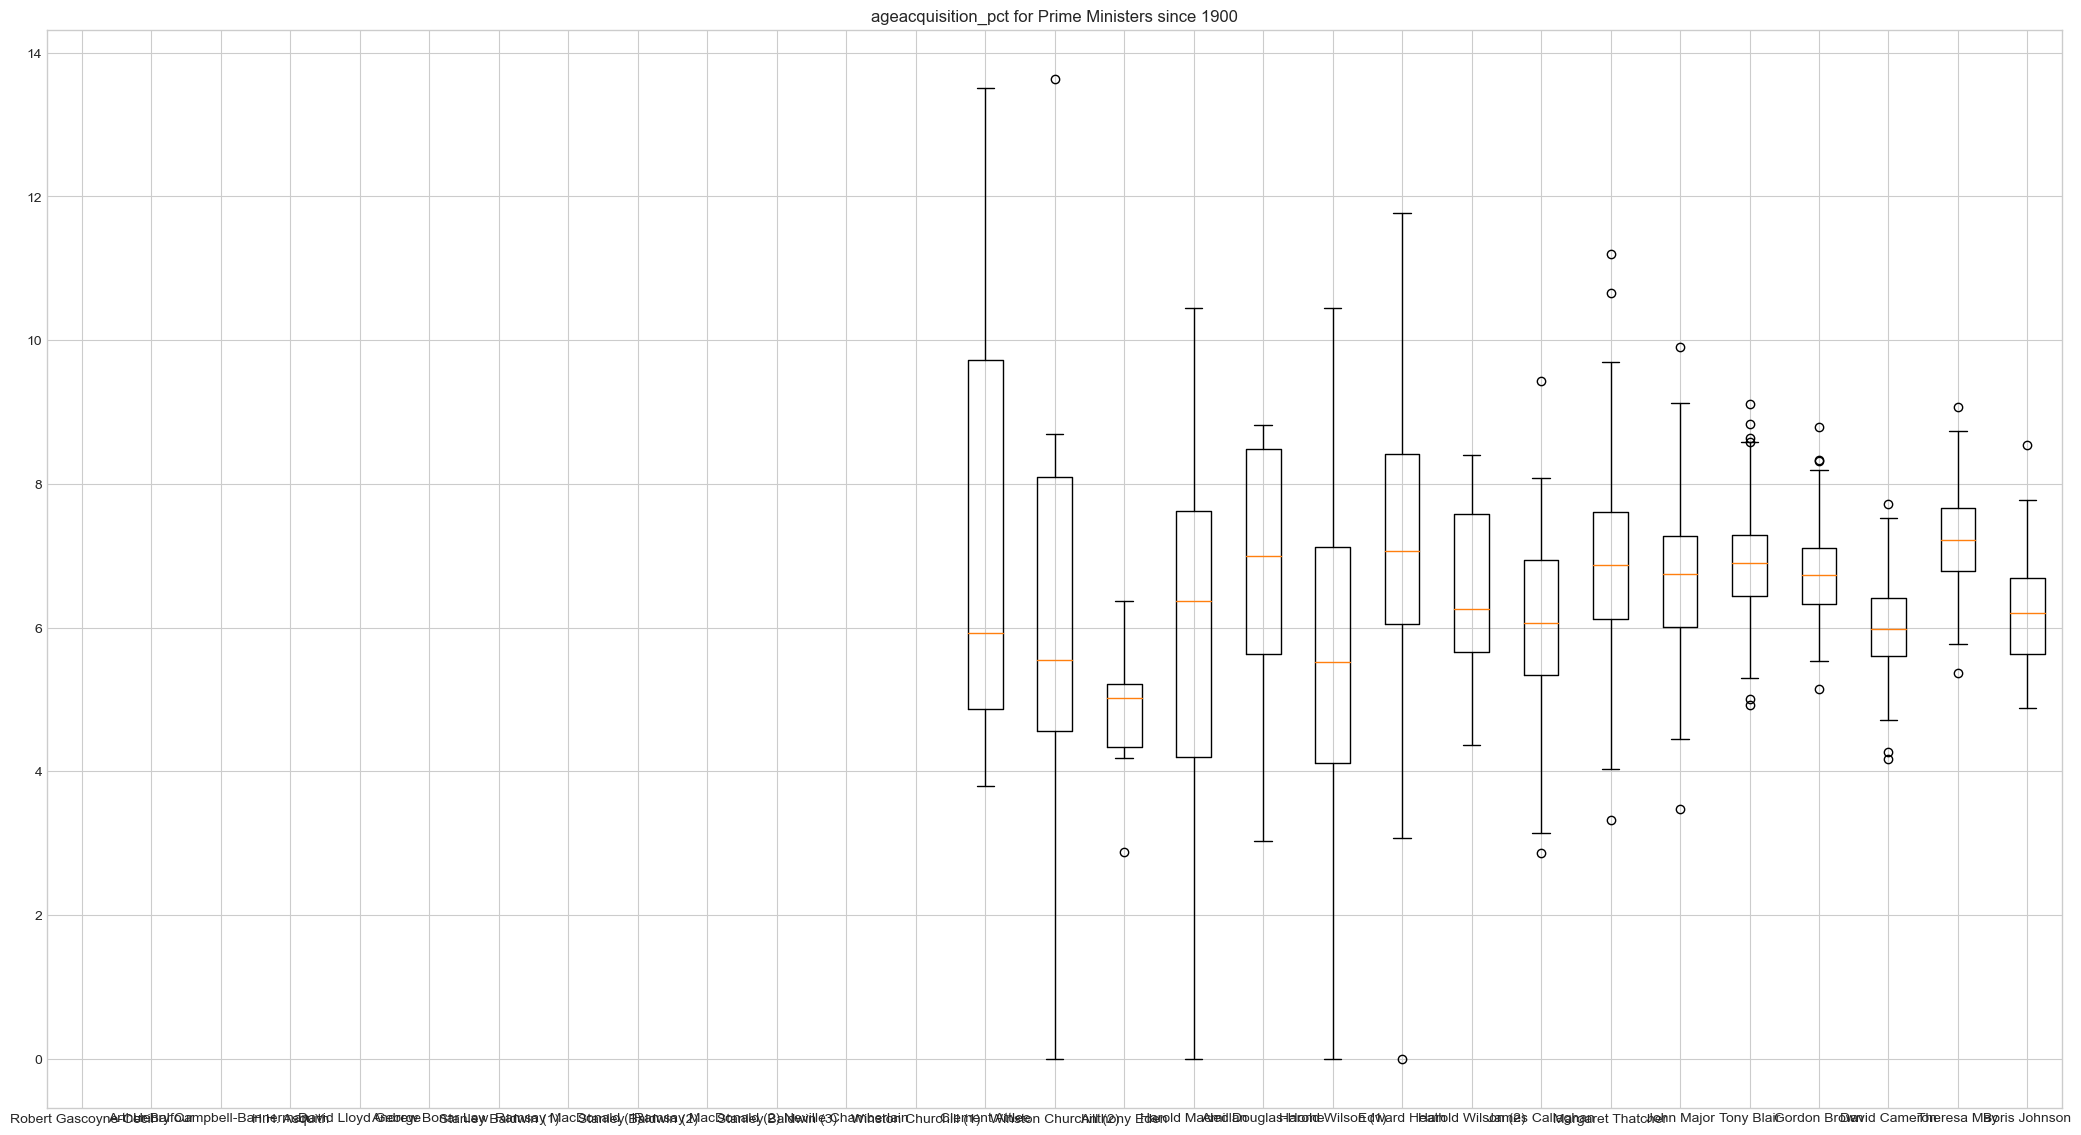

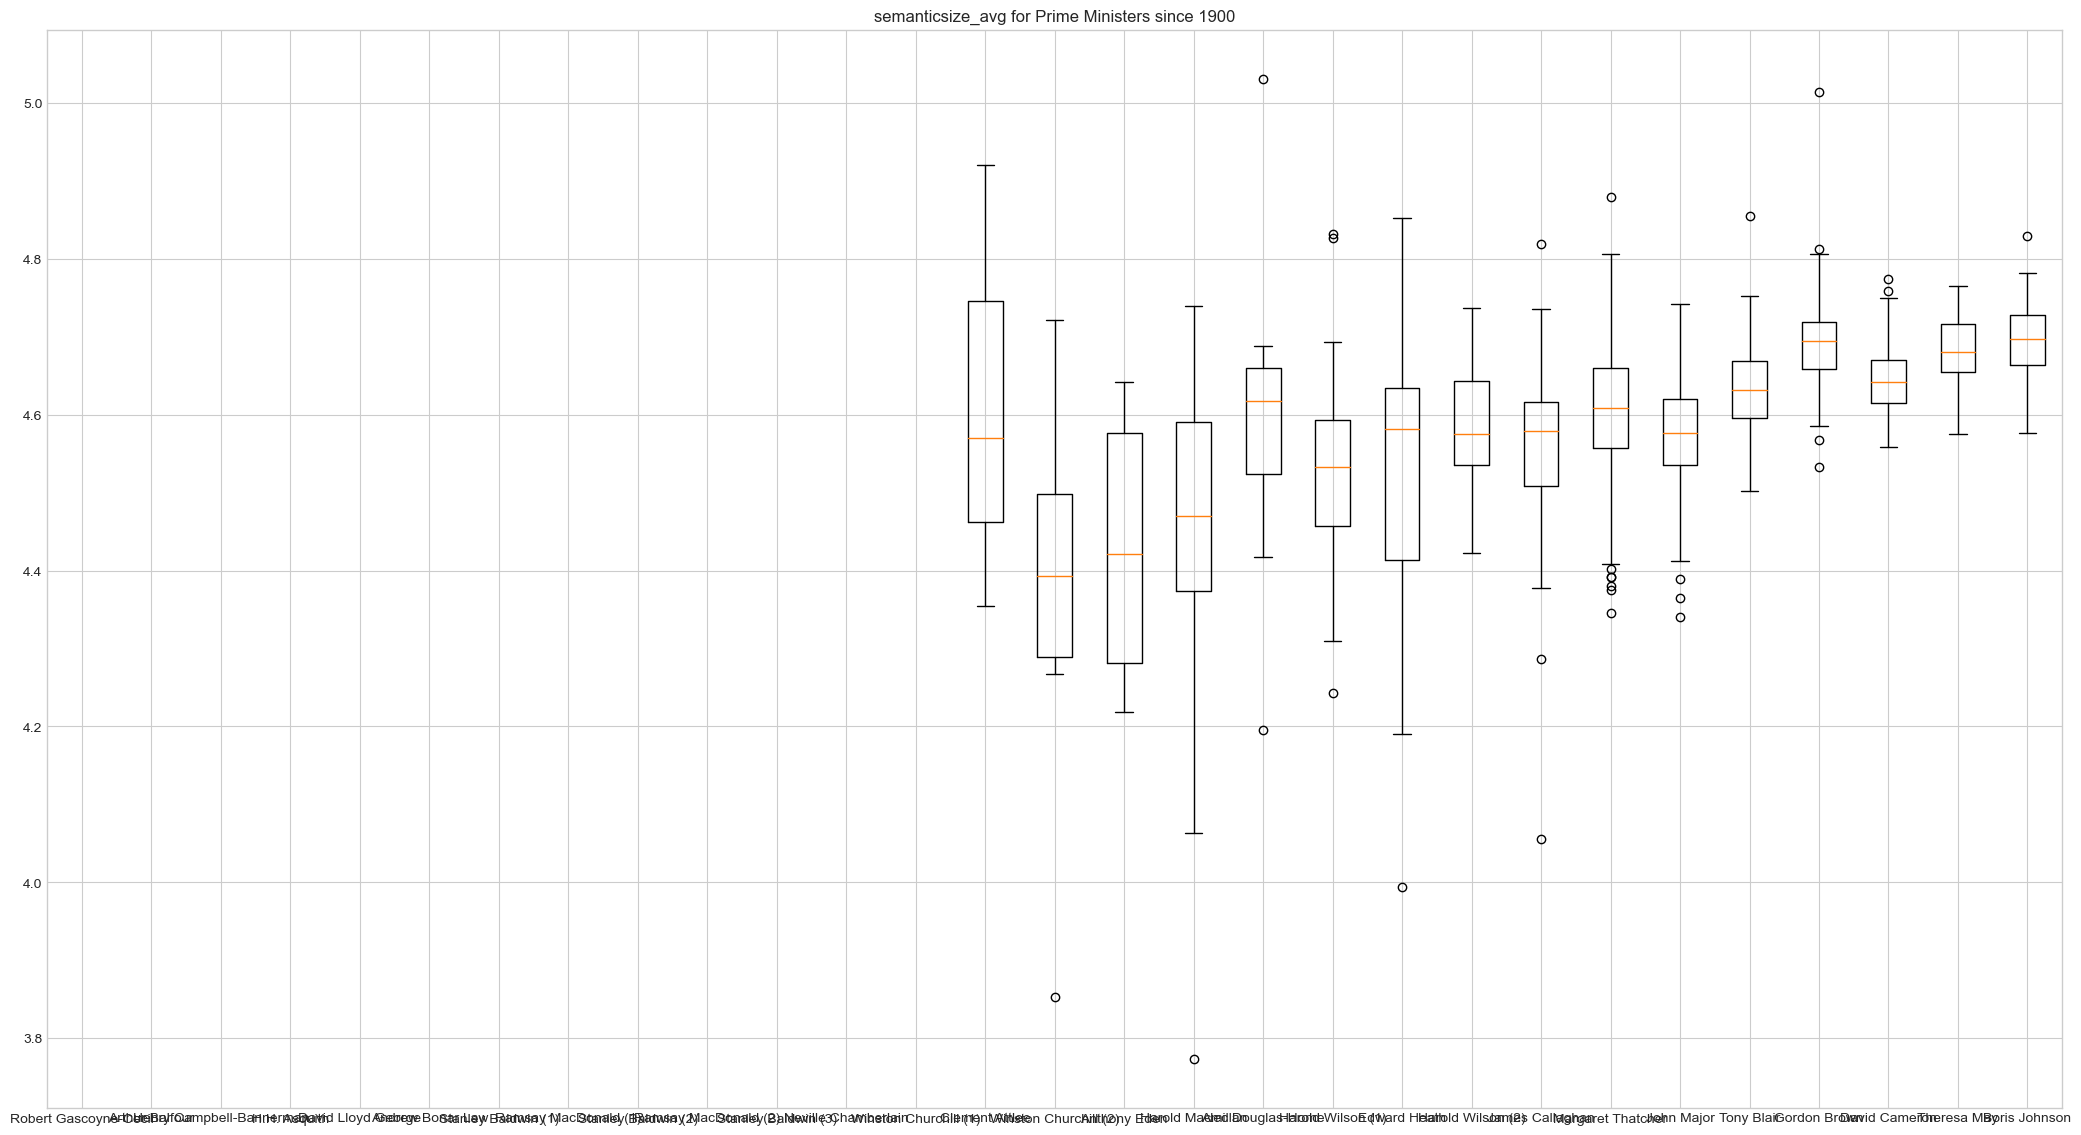

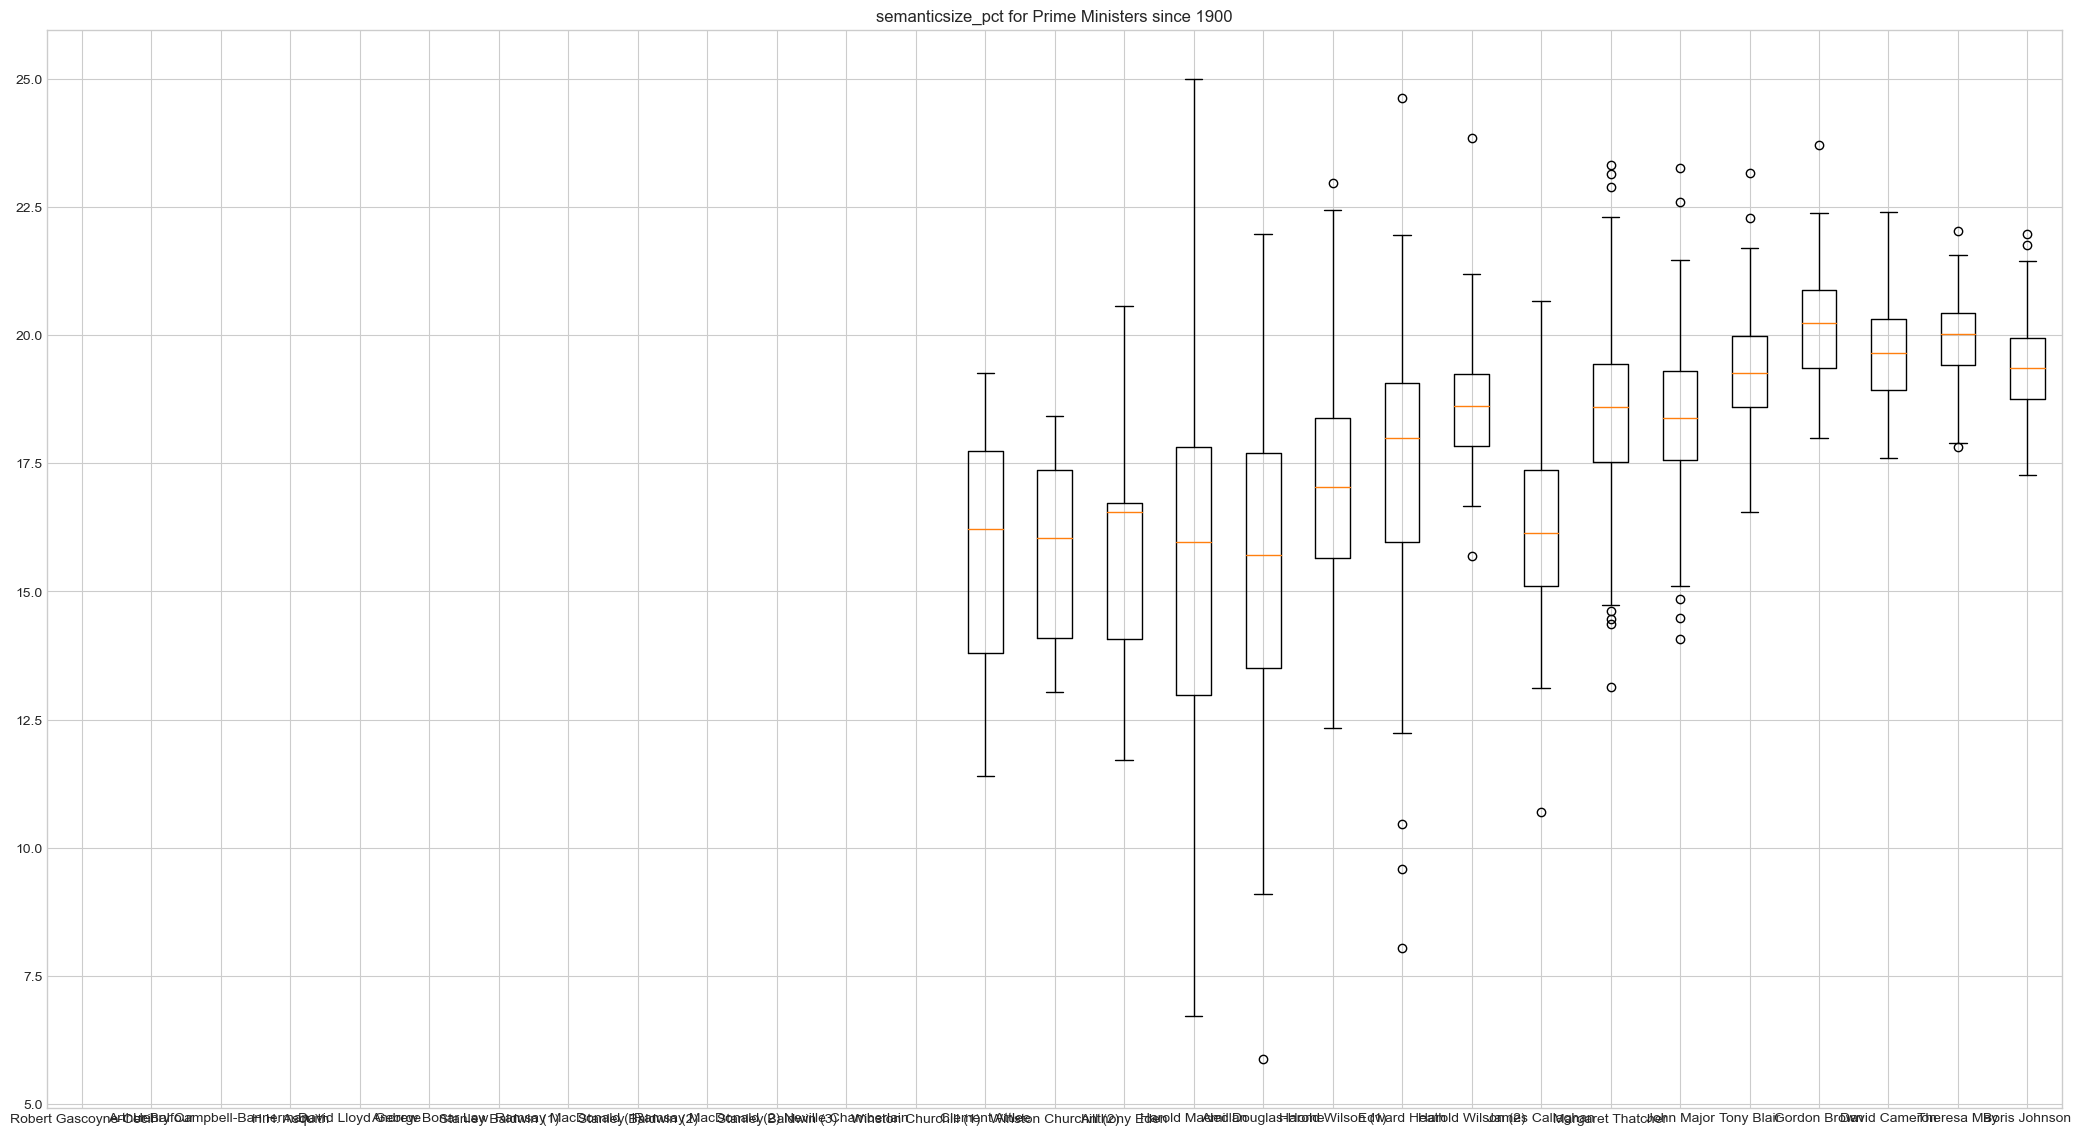

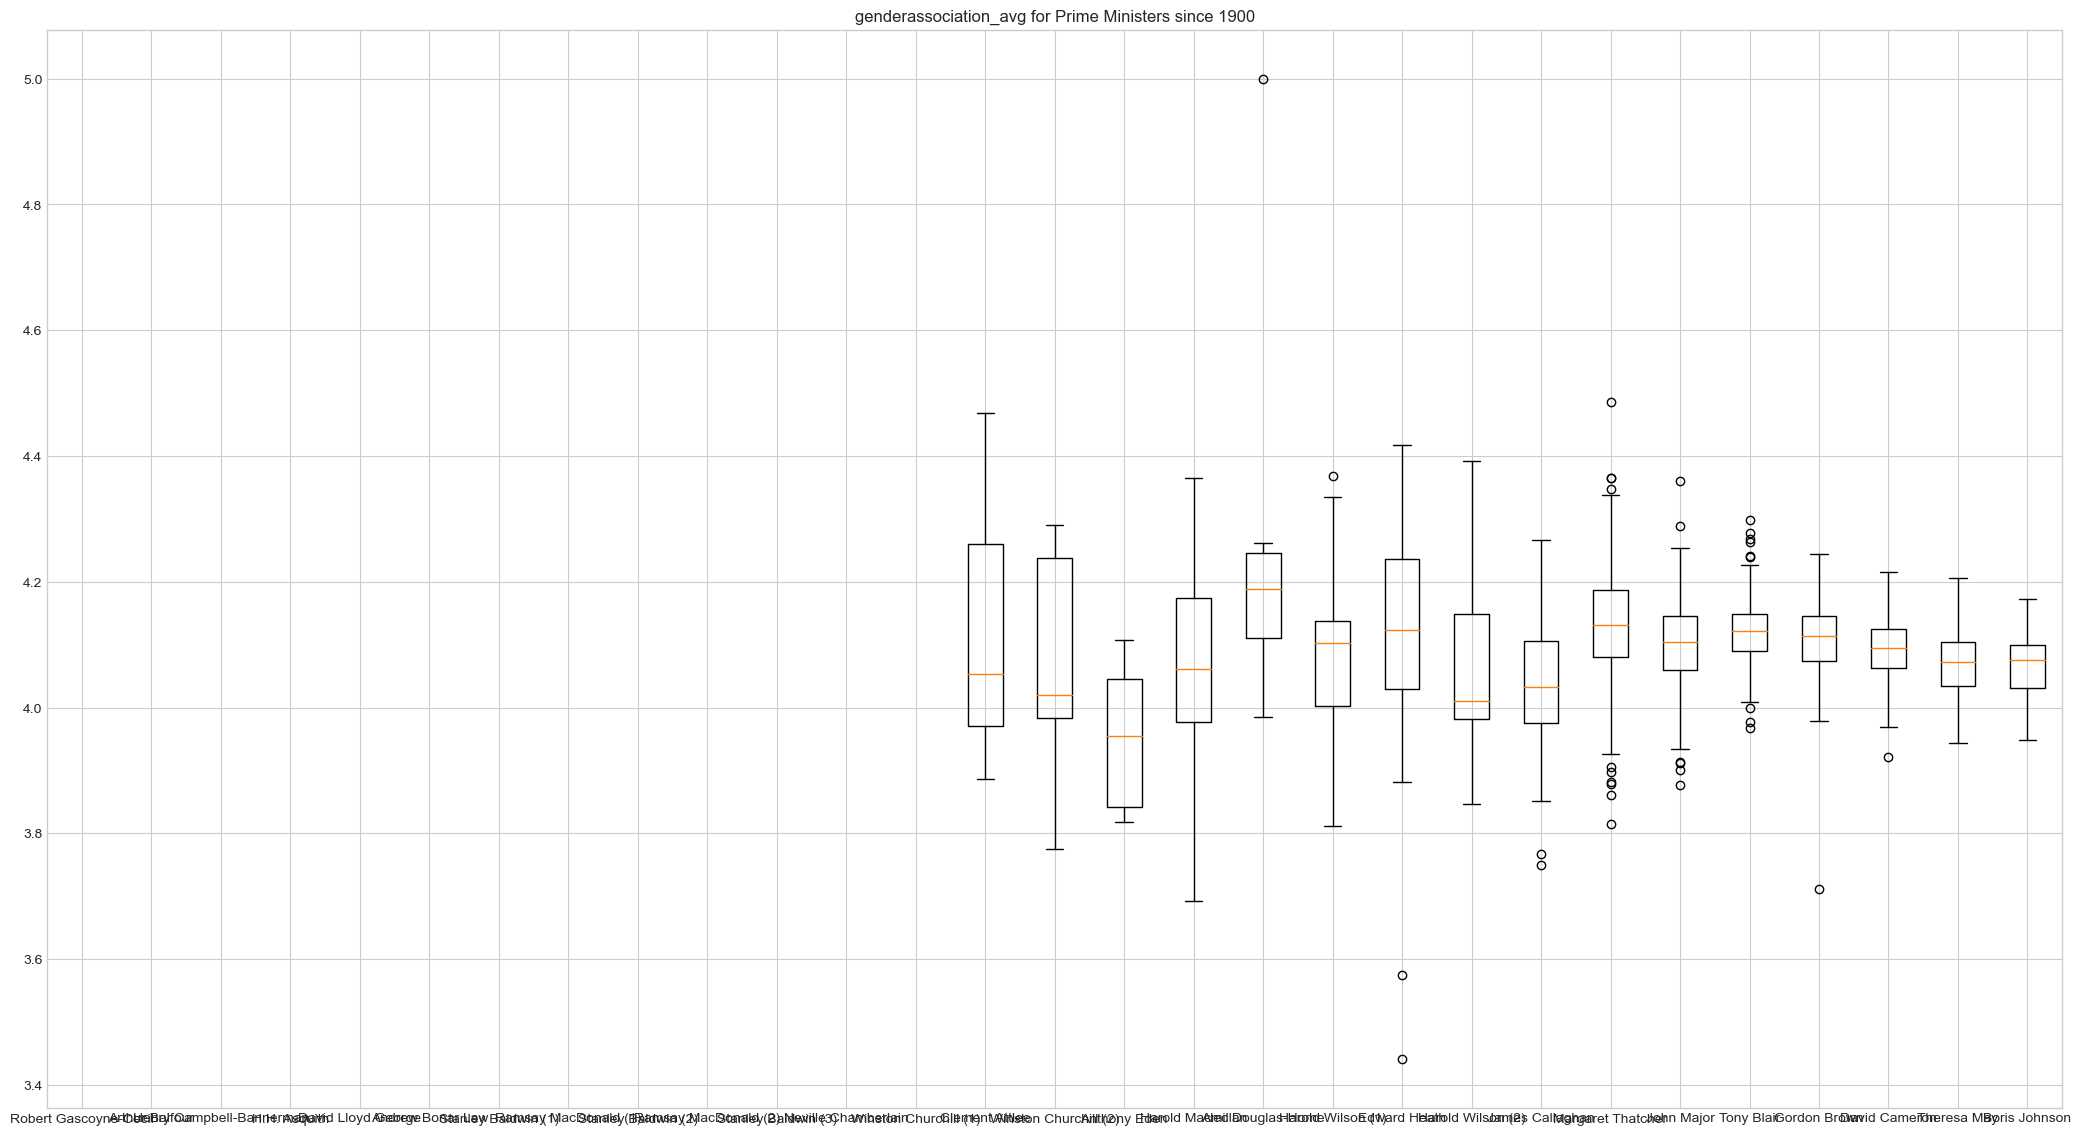

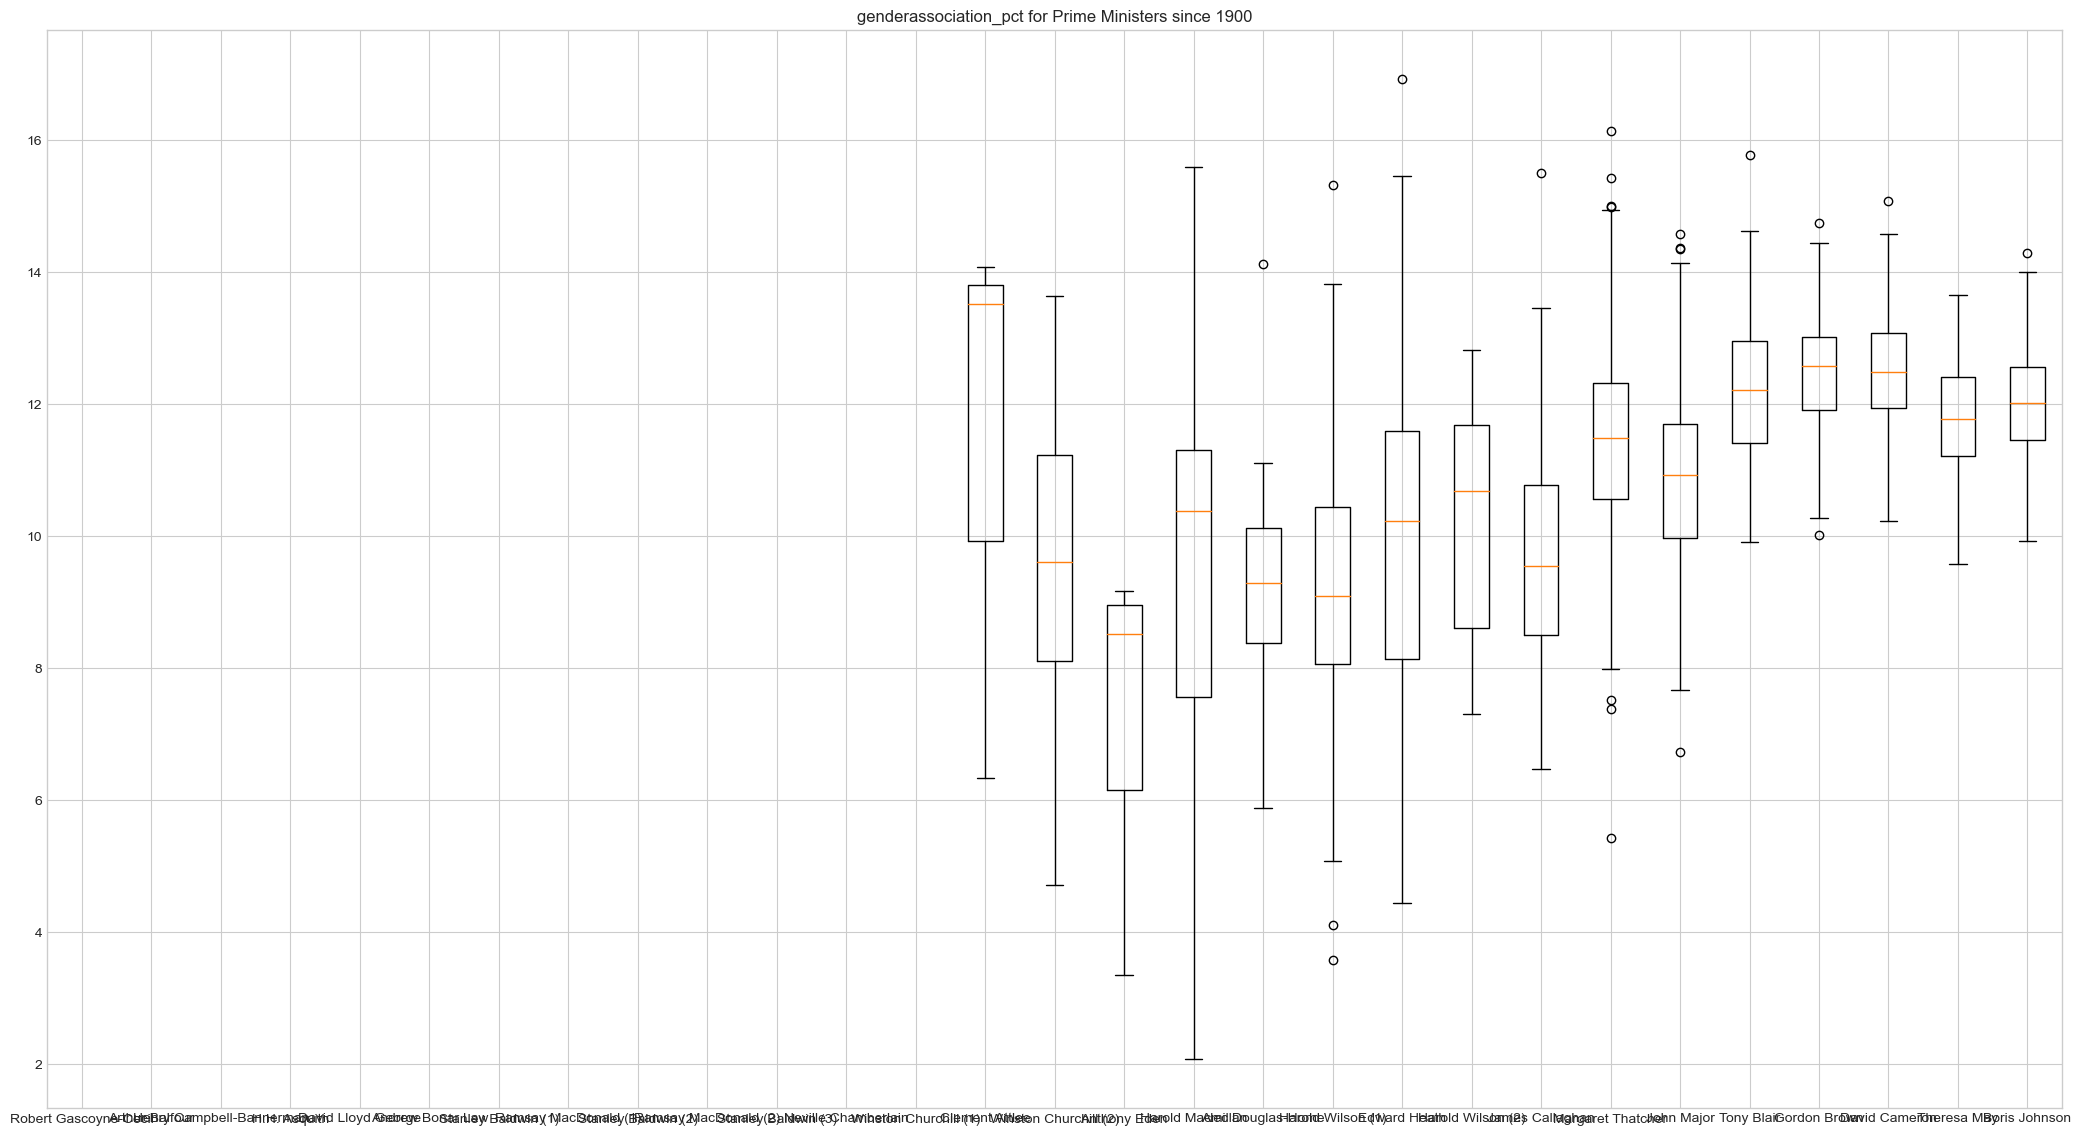

In [23]:
for scoring_var in pmqs.iloc[0,:].score.keys():
    fig,ax = plt.subplots(1, figsize=(26,14))
    ax.boxplot([pmqs[pmqs.answerer_name==pm[0]].score.apply(lambda entry: entry[scoring_var]).to_numpy() for pm in pm_list],
               labels=[pm[0] for pm in pm_list])
    ax.set_title(scoring_var+" for Prime Ministers since 1900")
    plt.show()